# Previsão de Preços de Imóveis de King County

Esse é um projeto tem por objetivo criar um modelo para prever o preço de venda de casas do King County. O dataset apresenta o preço que a casa foi vendia e suas características/atributos que são eles:

`id`: Um número que identifica a casa;

`date`: Data em que a casa foi vendida;

`price`: Preço que foi vendida (nossa variável target);

`bedrooms`: Número de quartos;

`bathrooms`: Número de banheiros;

`sqft_living`: Metragem quadrada da casa;

`sqft_lot`: Metragem quadrada do lote;

`floors`: Qtd de pisos/andares;

`waterfron`: Casa com vista para o mar;

`view`: Foi visualizado;

`condition`: Quão boa é a condição geral da casa;

`grade`: Nota geral dada à unidade habitacional, com base no sistema de classificação de King County;

`sqft_above`: Metragem quadrada de casa além do porão;

`sqft_basement`: Metragem quadrada do porão;

`yr_built`: Ano de construção;

`yr_renovated`: Ano que houve reformas;

`zipcode`: CEP;

`lat`: Latitude;

`long`: Longitude;

`sqft_living15`: Área da sala de estar em 2015 (implica algumas reformas);

`sqft_lot15`: Tamanho do lote em 2015 (implica algumas reformas);


São preços de casas vendidas entre maio de 2014 e maio de 2015. Este conjunto de dados foi obtido em: https://www.kaggle.com/harlfoxem/housesalesprediction/data

# Carregando os dados

In [1]:
# Primeiramente vamos carregar pacotes que serão utilizados na análise:

# Manipulação dos dados
import numpy as np
import pandas as pd
from math import sqrt

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Estatística
import pingouin as pg

# Pré processamento
from scipy.stats import boxcox 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Modelos de Machine Learning
from sklearn.linear_model import Lasso, Ridge, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectFromModel

# Otimização
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Avaliação de Métricas
from yellowbrick.regressor import ResidualsPlot, PredictionError
from yellowbrick.model_selection import CVScores, LearningCurve,FeatureImportances


# Filtrando avisos
import sys
import warnings
warnings.filterwarnings("ignore")

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('seaborn-darkgrid')

/home/jacque/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/jacque/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Carregando o dataset com pandas
df_original = pd.read_csv('kc_house_data.csv')

# Conhecendo os dados

A melhor maneira de entender o problema e as variáveis que estão a nossa disposição para resolve-lo é através de uma análise exploratória dos dados: **verificando a existência de valores nulos**, **checando o type deles** e **coletando a estratística descritiva deles** para, posteriormente, preparar o conjunto de dados para coletarmos insights.

In [3]:
# Verificando as 10 primeiras linhas do dataset
df_original.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [4]:
# Checando o número de linhas e colunas do dataset
print('O número de linhas é: ', df_original.shape[0])
print('O número de colunas é: ', df_original.shape[1])

O número de linhas é:  21613
O número de colunas é:  21


In [5]:
# Verificando se há valores nulos
df_original.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Não há valores nulos

In [6]:
# Resumo estatistico das variáveis
df_original.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [7]:
# Verificando o type de cada uma das variáveis
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

# Limpeza e transformação dos dados

Essas serão algumas transformações que vão nos possibilitar olhar para os dados de forma mais agregada e que seja possível coletar informações.

Primeiramente vamos ajustar o `type` das variáveis que foram carregadas.

Posteriormente vamos atribuir às variáveis categóricas: `waterfront`, `view`, `condition` e `grade` nova categorização.

E, por fim, vamos criar novas categorias para as variáveis`yr_built` e `yr_renovated`.

In [8]:
# Criando uma cópia do dataset original
df = df_original.copy()

In [9]:
# Excluindo variáveis (colunas) irrelevantes para a análise
# A variáveis yr_renovated possuía mais de 90% dos valores igual a zero, por isso removemos ela.
df.drop(columns = ['id', 'date', 'yr_renovated'], axis=1, inplace=True)

In [10]:
# Selecionando as variáveis qualitativas
var_qualitativa = ['waterfront',
                   'view',
                   'condition',
                   'grade']

In [11]:
# Selecionando as variáveis quantitativas
var_quantitativa = ['price', 
                    'bedrooms', 
                    'bathrooms',
                    'sqft_living', 
                    'sqft_lot',
                    'floors',
                    'sqft_above',
                    'sqft_basement',
                    'sqft_living15',
                    'sqft_lot15']

In [12]:
# Selecionando variáveis do tipo quantitativa discreta.
var_quant_discreta = ['bathrooms',
                      'bedrooms',
                      'floors']

In [13]:
# Selecionando variáveis quantitativa contínua.
var_quant_continua = ['price',              
                 'sqft_living',
                 'sqft_lot',
                 'sqft_above',
                 'sqft_basement',
                 'sqft_living15',
                 'sqft_lot15']

In [14]:
# Convertendo os tipos de variáveis numéricas para categórica
for i in df:
    df[var_qualitativa]=df[var_qualitativa].astype('category')

# Convertendo os tipos em variáveis float64 em int64
for i in df:
    df[var_quant_discreta]=df[var_quant_discreta].astype('int64')
    
# Convertendo os tipos em variáveis float64 em int64
for i in df:
    df[var_quant_continua]=df[var_quant_continua].astype('float64')
    
# Checando a transformação
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          21613 non-null  float64 
 1   bedrooms       21613 non-null  int64   
 2   bathrooms      21613 non-null  int64   
 3   sqft_living    21613 non-null  float64 
 4   sqft_lot       21613 non-null  float64 
 5   floors         21613 non-null  int64   
 6   waterfront     21613 non-null  category
 7   view           21613 non-null  category
 8   condition      21613 non-null  category
 9   grade          21613 non-null  category
 10  sqft_above     21613 non-null  float64 
 11  sqft_basement  21613 non-null  float64 
 12  yr_built       21613 non-null  int64   
 13  zipcode        21613 non-null  int64   
 14  lat            21613 non-null  float64 
 15  long           21613 non-null  float64 
 16  sqft_living15  21613 non-null  float64 
 17  sqft_lot15     21613 non-null  

In [15]:
# Agrupando a variável waterfront e modificando os valores.

df['waterfront'] = df['waterfront'].map({0: 'NO',
                                         1: 'YES'
                        })
# Verificando a frequência do novo atributo
pd.crosstab(index=df['waterfront'], columns='Count')

col_0,Count
waterfront,
NO,21450
YES,163


In [16]:
# Agrupando a variável view e modificando os valores.

df['view'] = df['view'].map({0: 'NO',
                             1: 'YES',
                             2: 'YES', 
                             3: 'YES', 
                             4: 'YES', 
                        })
# Verificando a frequência do novo atributo
pd.crosstab(index=df['view'], columns='Count')

col_0,Count
view,
NO,19489
YES,2124


In [17]:
# Agrupando a variável condition e modificando os valores.

df['condition'] = df['condition'].map({1: 'BAD',
                                       2: 'BAD',
                                       3: 'REGULAR', 
                                       4: 'GOOD',
                                       5: 'GOOD'
                        })
# Verificando a frequência do novo atributo
pd.crosstab(index=df['condition'], columns='Count')

col_0,Count
condition,
BAD,202
GOOD,7380
REGULAR,14031


In [18]:
# Agrupando as variável grade e modificando os valores.

df['grade'] = df['grade'].map({1: 'BAD',
                               2: 'BAD',
                               3: 'BAD',
                               4: 'BAD',
                               5: 'BAD',
                               6: 'BAD',
                               7: 'REGULAR',
                               8: 'GOOD',
                               9: 'GOOD',
                               10: 'GOOD',
                               11: 'GOOD',
                               12: 'GOOD',
                               13: 'GOOD'
                        })
# Verificando a frequência do novo atributo
pd.crosstab(index=df['grade'], columns='Count')

col_0,Count
grade,
BAD,2313
GOOD,10319
REGULAR,8981


In [19]:
# A data inicial do ano de construção das casas é 1900 e o final é 2015
# Criamos uma nova variável categorizando por década.

def cria_decada_built(df) :
    
    if (df["yr_built"] >= 1900) & (df["yr_built"]<=1909):
        return "dec_built1900"
    elif (df["yr_built"] >= 1910) & (df["yr_built"]<=1919):
        return "dec_built1910"
    elif (df["yr_built"] >= 1920) & (df["yr_built"]<=1929):
        return "dec_built1920"
    elif (df["yr_built"] >= 1930) & (df["yr_built"]<=1939):
        return "dec_built1930"
    elif (df["yr_built"] >= 1940) & (df["yr_built"]<=1949):
        return "dec_built1940"
    elif (df["yr_built"] >= 1950) & (df["yr_built"]<=1959):
        return "dec_built1950"
    elif (df["yr_built"] >= 1960) & (df["yr_built"]<=1969):
        return "dec_built1960"
    elif (df["yr_built"] >= 1970) & (df["yr_built"]<=1979):
        return "dec_built1970"
    elif (df["yr_built"] >= 1980) & (df["yr_built"]<=1989):
        return "dec_built1980"
    elif (df["yr_built"] >= 1990) & (df["yr_built"]<=1999):
        return "dec_built1990"
    elif (df["yr_built"] >= 2000) & (df["yr_built"]<=2009):
        return "dec_built2000"
    elif (df["yr_built"] >= 2010) & (df["yr_built"]<=2019):
        return "dec_built2010"
    
df["decada_built"] = df.apply(lambda df:cria_decada_built(df), axis = 1)

In [20]:
# Convertendo os tipos de variáveis numéricas para categórica
df['decada_built']=df['decada_built'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          21613 non-null  float64 
 1   bedrooms       21613 non-null  int64   
 2   bathrooms      21613 non-null  int64   
 3   sqft_living    21613 non-null  float64 
 4   sqft_lot       21613 non-null  float64 
 5   floors         21613 non-null  int64   
 6   waterfront     21613 non-null  category
 7   view           21613 non-null  object  
 8   condition      21613 non-null  object  
 9   grade          21613 non-null  object  
 10  sqft_above     21613 non-null  float64 
 11  sqft_basement  21613 non-null  float64 
 12  yr_built       21613 non-null  int64   
 13  zipcode        21613 non-null  int64   
 14  lat            21613 non-null  float64 
 15  long           21613 non-null  float64 
 16  sqft_living15  21613 non-null  float64 
 17  sqft_lot15     21613 non-null  

# Obtendo insights

Agora com os nossos dados devidamente manipulados, vamos gerar alguns gráficos e tabelas com os dados e coletar insights.

Primeiro, vamos gerar as visualizações das variáveis categóricas para identificar a frequência de cada categoria de cada variável, também vamos confrontá-las com a variável target atravéz de um boxplot, e finalizando a exploração das variáveis qualitativas, vamos plotar as médias de preços por cada categoria dessas variáveis.

Posteriormente, vamos gerar  visualizações das variáveis quantitativas, identificar as distribuições de frequência de algumas delas, entender a sua relação com a variável target e para finalizar a exploração das variáveis quantitativas, vamos plotar as médias de preços por cada categoria das variáveis que são quantitativas discreta.

Neste processo irá surgir novas necessidades de transformações, essas serão realizadas na próxima sessão.

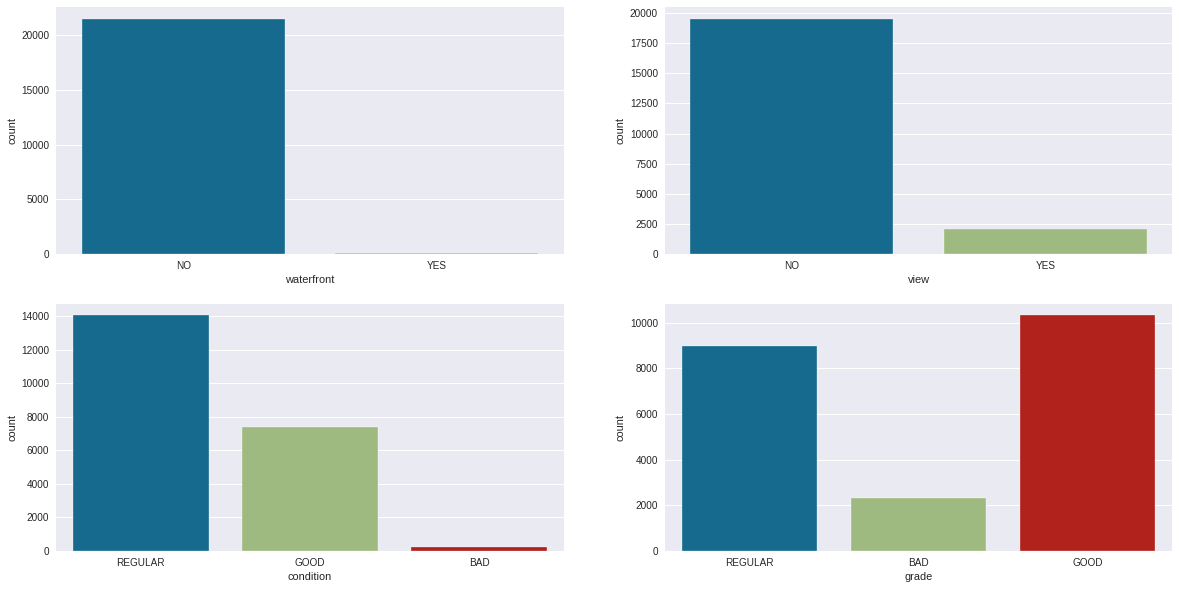

In [21]:
# Quantidade de casas com vista para o mar (waterfront),  visualizadas (view), por condição (condition) e 
# pela nota geral da King County (grade)

fig, axes = plt.subplots(2,2)
axes = axes.flatten()
cat_vars = ['waterfront', 'view', 'condition', 'grade']

for ax, catplot in zip(axes, df[cat_vars]):
    sns.countplot(x=catplot, ax=ax, data=df)
plt.show()

Foram vendidas mais casas que não possuíam vista para o mar, que não foram visualizadas, grande parte estavam em situação regular e boa, e com boa e regular avaliação. 

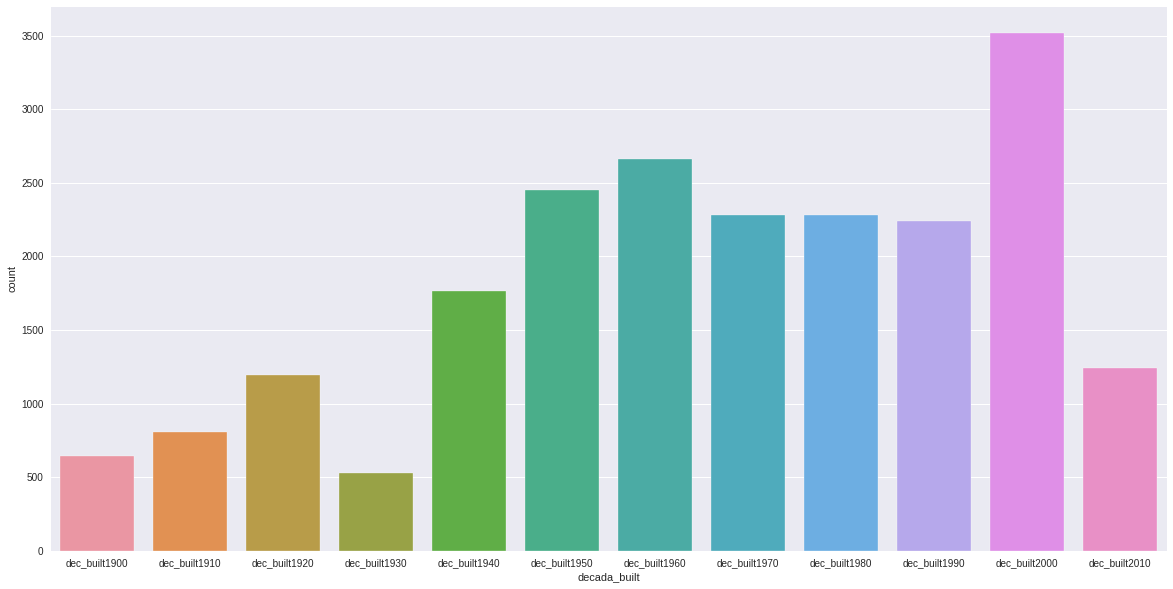

In [22]:
# Checando a quantidade de casas construídas por década.
sns.countplot(x=df['decada_built'], data=df)

Grande parte das casa foram construídas na dácada de 2000.

Agora, vamos avaliar o comportamento dessas variáveis categóricas confrontadas com a nossa variável target, através de um boxplot.

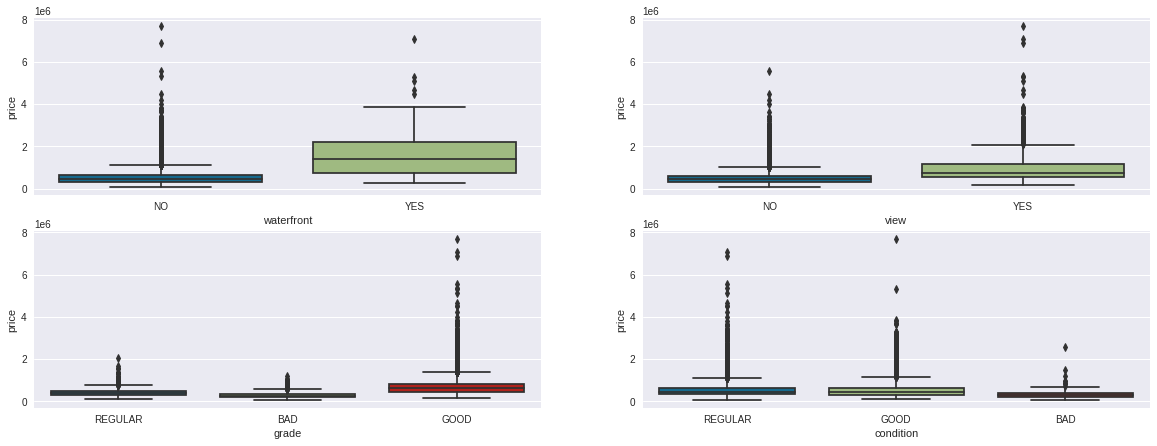

In [23]:
# Boxplot das variáveis categóricas pelo preço 
plt.figure(figsize=(20,15))
plt.subplot(4,2,1)
sns.boxplot(x='waterfront', y='price', data=df)

plt.subplot(4,2,2)
sns.boxplot(x='view', y='price', data=df)

plt.subplot(4,2,3)
sns.boxplot(x='grade', y='price', data=df)

plt.subplot(4,2,4)
sns.boxplot(x='condition', y='price', data=df)


plt.show()

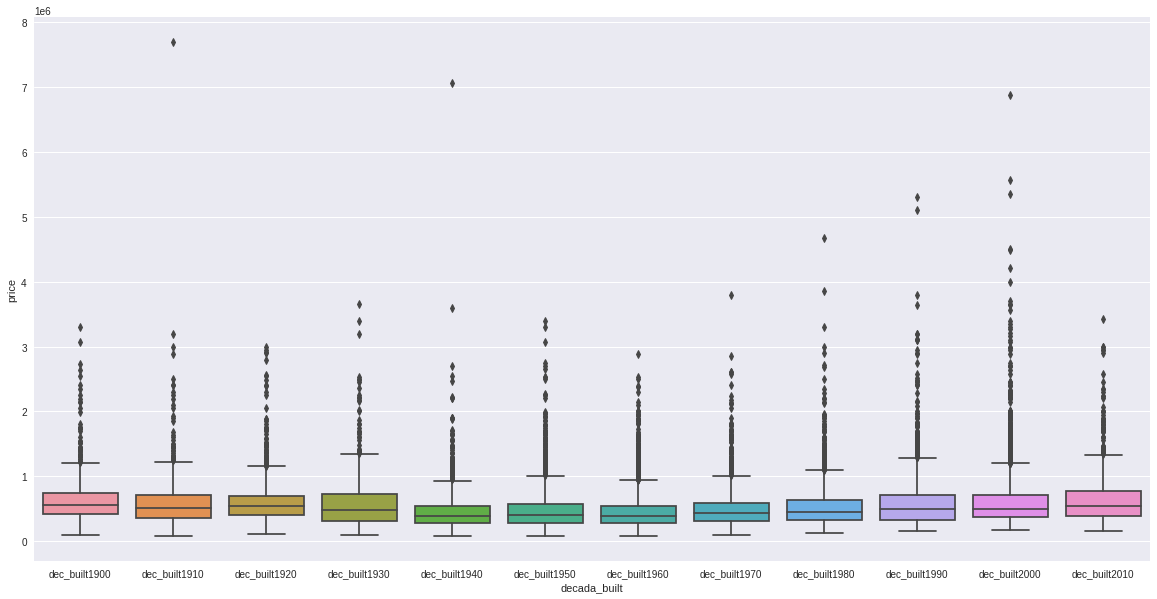

In [24]:
# Boxplot da variável ano de construção pelo preço
sns.boxplot(x='decada_built', y='price', data=df)

A seguir, para complementar a análise dos boxplots, vamos identificar qual o preço médio das casas de acordo com os atributos: se a casa possui vista para o mar, se foi ou não visualizada, qual a sua classificação na King County, sua condição e década de construção.

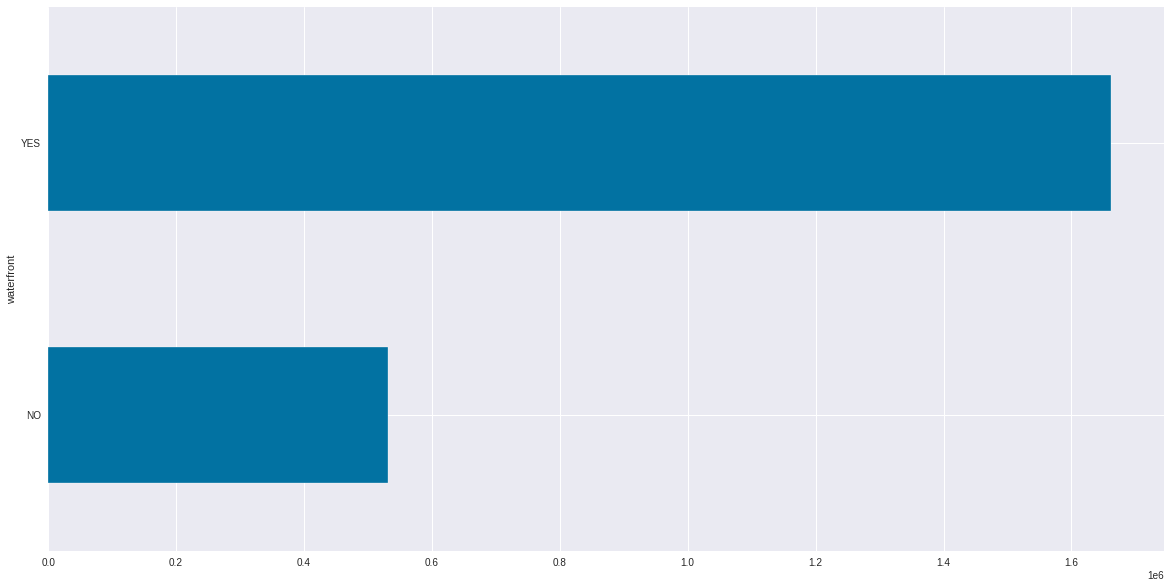

In [25]:
# Média de preço de casas que possuem vista para o mar
df.groupby('waterfront')['price'].mean().sort_values().plot(kind='barh')

Casas que possuem vista para o mar apresentaram média de preços maior que casas que não possuiam vista para o mar.

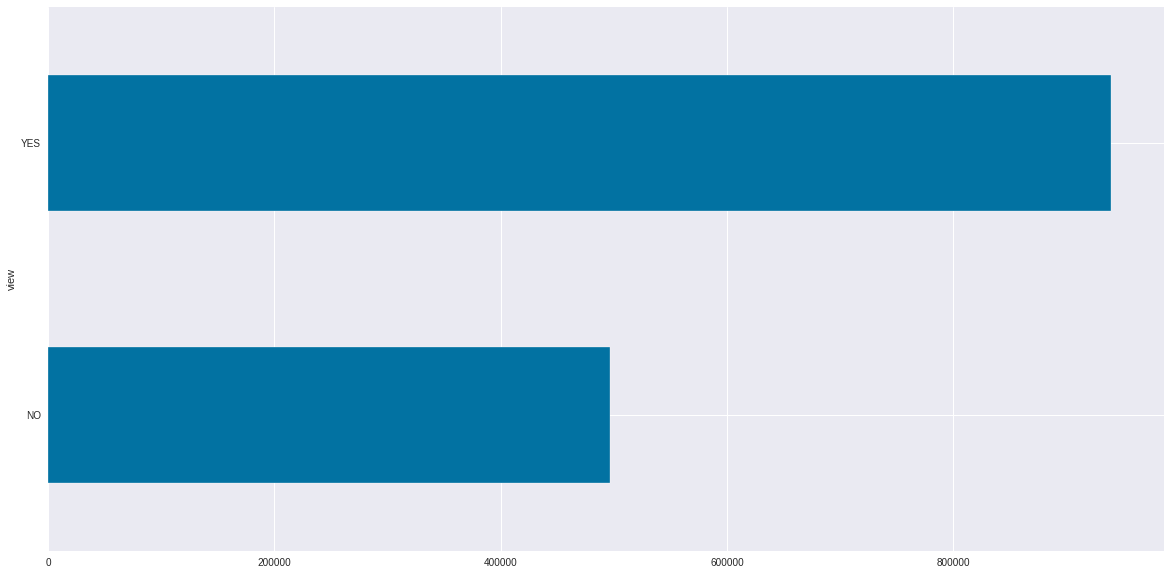

In [26]:
# Média de preço de casas pela variável view
df.groupby('view')['price'].mean().sort_values().plot(kind='barh')

Casas que foram visualizadas também apresentaram média de preços maior do que as casa que não foram visualizadas.

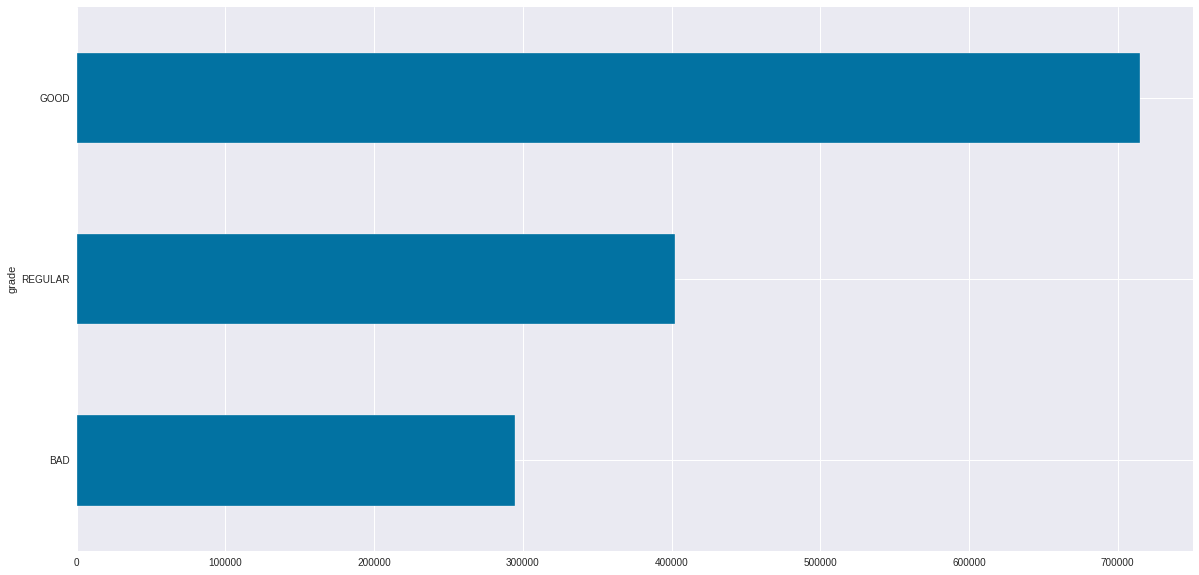

In [27]:
# Média de preço de casas pela variável grade
df.groupby('grade')['price'].mean().sort_values().plot(kind='barh')

Casas melhor avaliadas apresentaram média de preços maior que as casas avaliadas como regular e ruim.

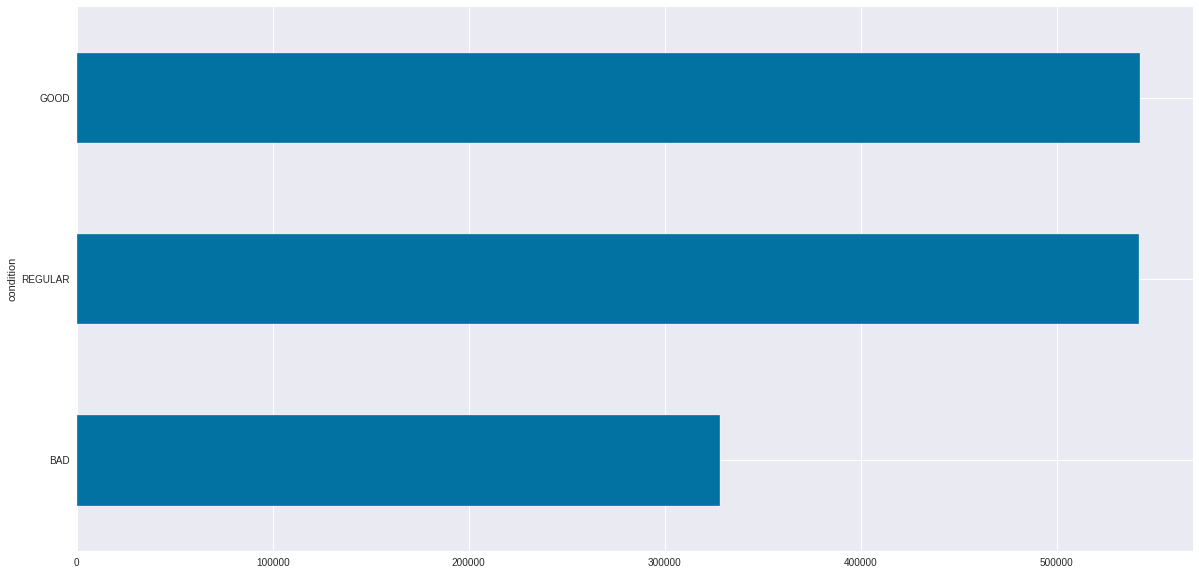

In [28]:
# Média de preço de casas pela condição
df.groupby('condition')['price'].mean().sort_values().plot(kind='barh')

Casas em condições regular e boa apresentaram quase a mesma média de preços.

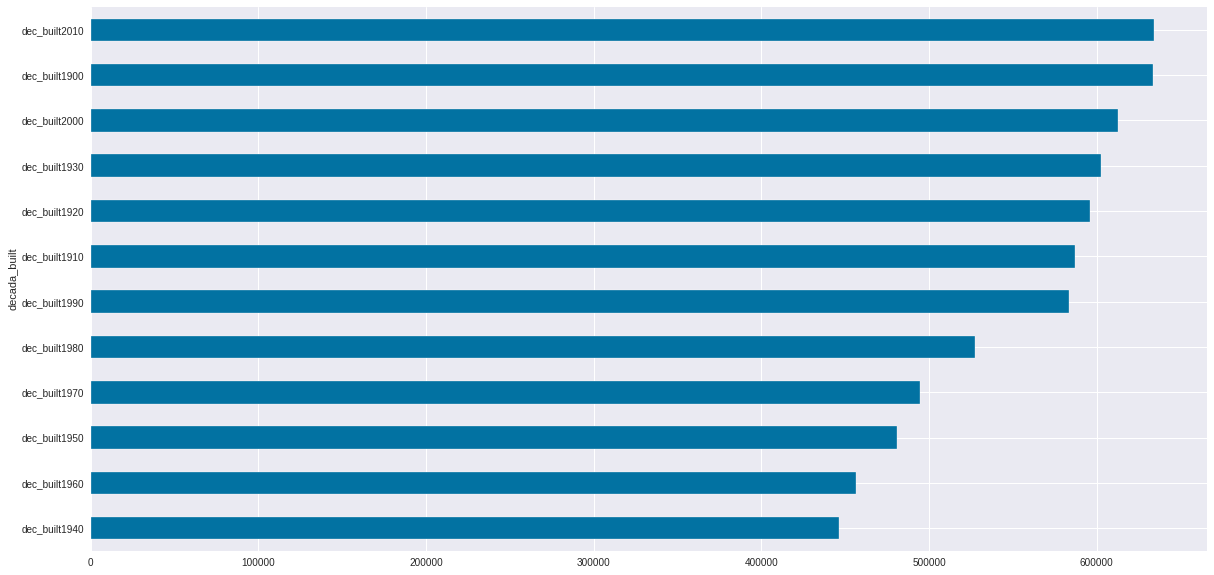

In [29]:
# Média de preço de casas pela década de construção
df.groupby('decada_built')['price'].mean().sort_values().plot(kind='barh')

Casas que foram construídas nas décadas de 2010 e 1900 apresentaram a maior média de preços.

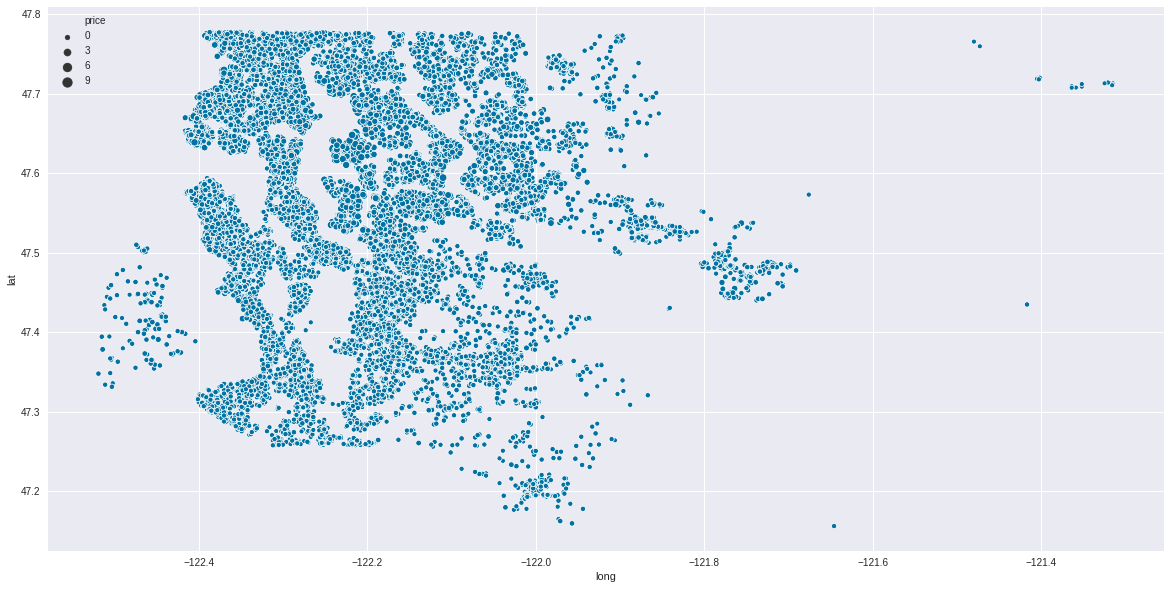

In [30]:
# Verificando a latitude e longitude
sns.scatterplot(x="long", y="lat",
                size=(df['price']),
                data=df)

Agora, vamos avalizar a variável target, identificar a sua distribuição. Além dela, vamos avaliar as demais variáveis quantitativas.

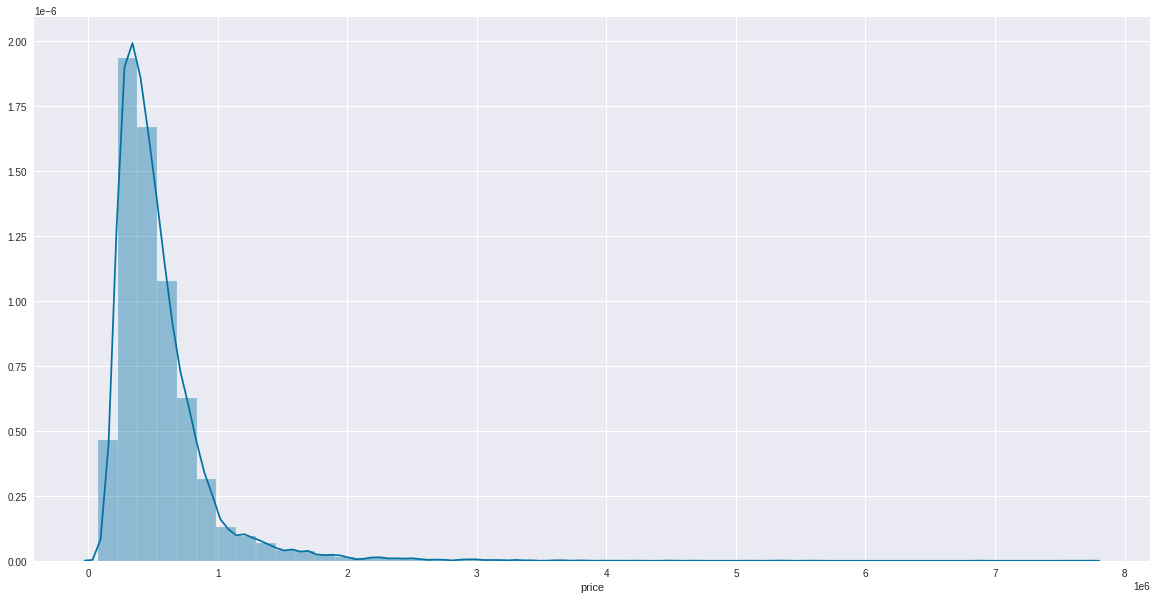

In [31]:
# Avaliando a nossa variável target através de um histograma
sns.distplot(df['price'], hist=True)
plt.show()

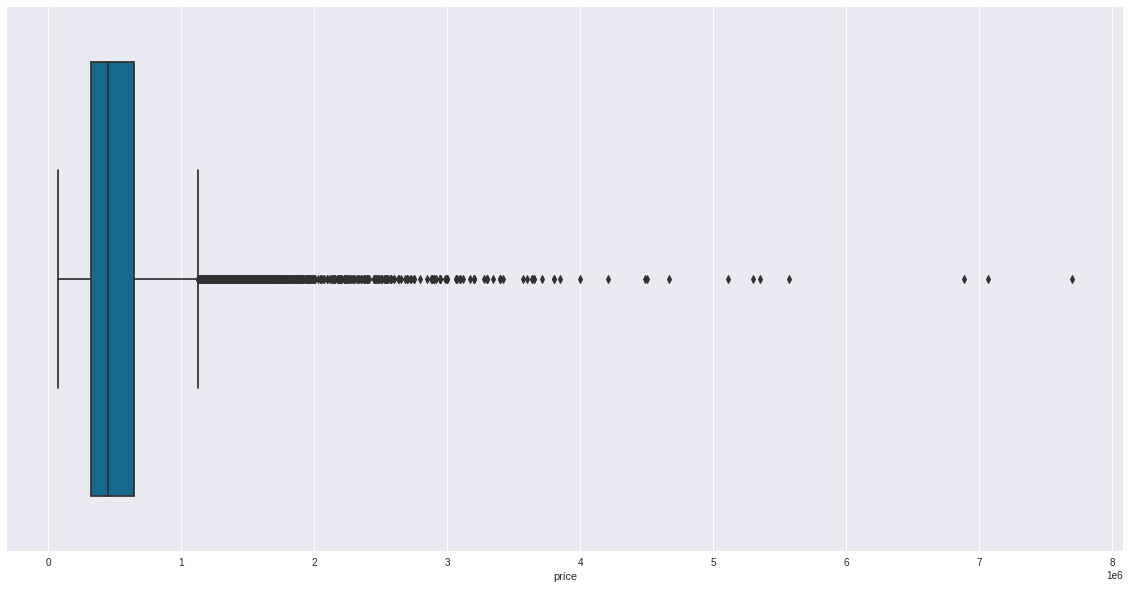

In [32]:
# Avaliando a nossa variável target através de um boxplot
sns.boxplot(y='price', data=df, orient='h')
plt.show()

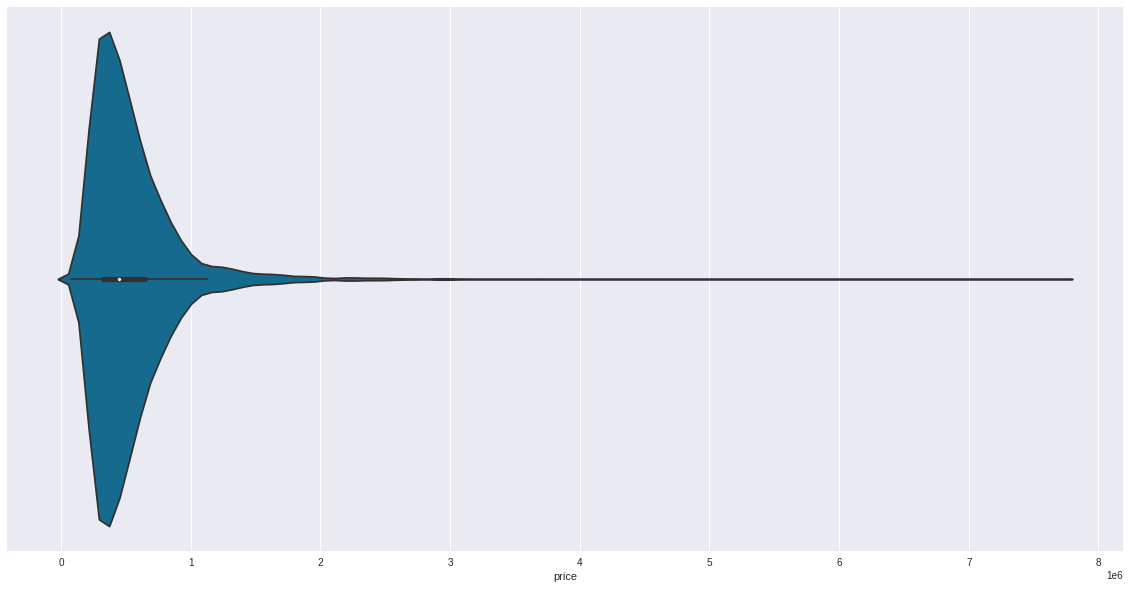

In [33]:
# Avaliando a nossa variável target através de um gráfico de violino
sns.violinplot(y='price', orient='h', data=df)
plt.show()

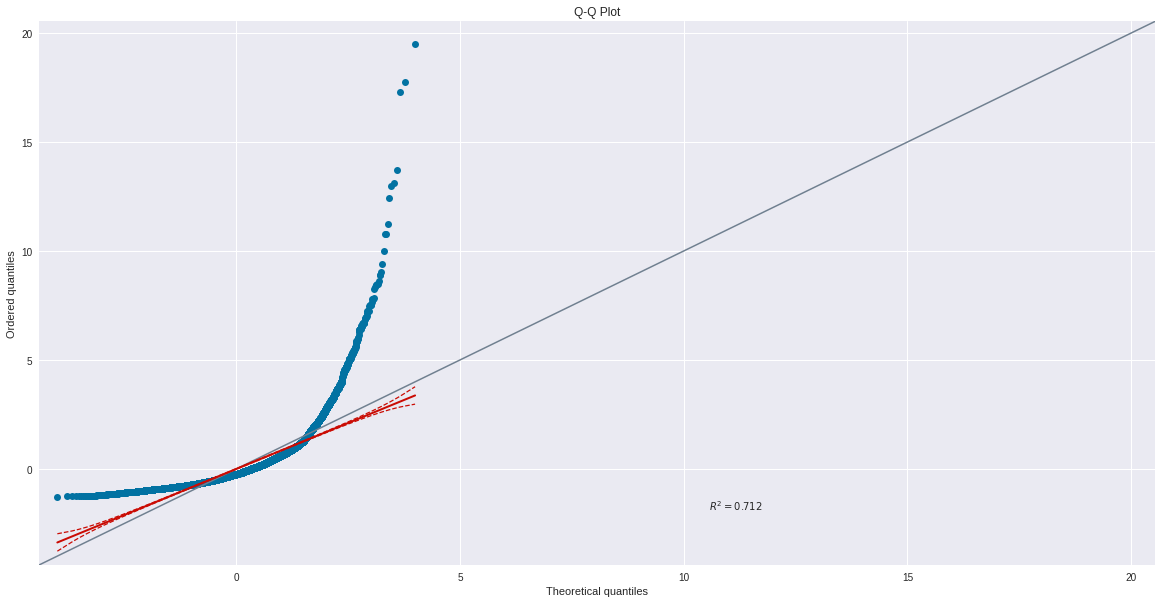

In [34]:
# Visualizar a distribuição da variável Price utilizando o QQ-Plot
ax=pg.qqplot(df['price'], dist='norm', figsize=(20,10))
plt.show()

Como pôde ser observado no gráfico de distribuição, a nossa variável target não apresentou uma distribuição normal. No boxplot podemos observar a grande quantidade de outliers. E o violin plot confirma a distribuição e a existência de outliers. No gráfico Q-Q Plot, ela apresentou um R²=0.712, o ideal é o mais próximo de 1. 
A seguir, iremos tratar a variável target antes de darmos início ao treinamento do modelo.

Agora, vamos avaliar o comportamento das demais variáveis quantitativas, identificar a presença de outliers para depois tratá-los.

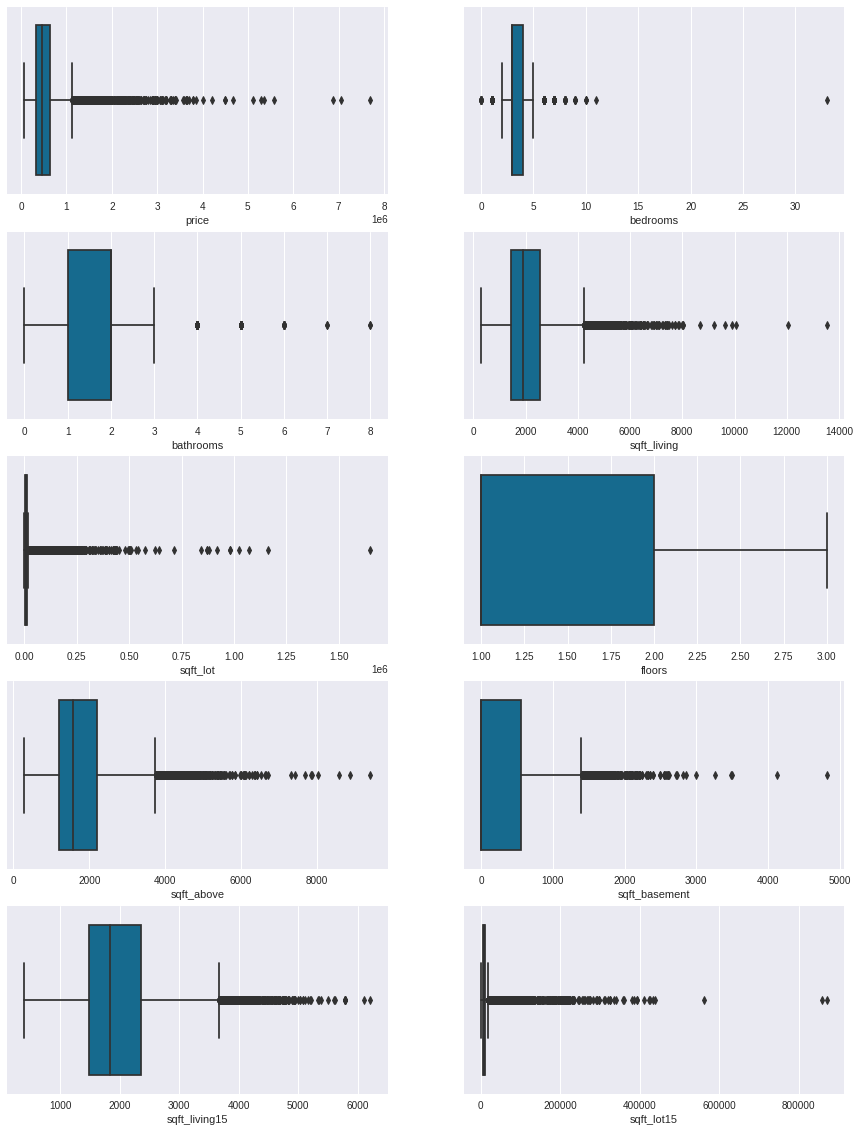

In [35]:
# Boxplot das variáveis quantitativas. 

fig, axes = plt.subplots(5,2, figsize=(15,20))
axes = axes.flatten()

for ax, catplot in zip(axes, df[var_quantitativa]):
    sns.boxplot(x=catplot, ax=ax, data=df)
plt.show()

Exceto a variável `floors`, todas as demais apresentaram outliers. Mais a frente iremos tratar esses outliers.
Prosseguindo com a nossa análise das variáveis quantitativas, vamos plotar um pairplot com todas as variáveis quantitativas e identificar se há alguma relação aparente com a variável target.

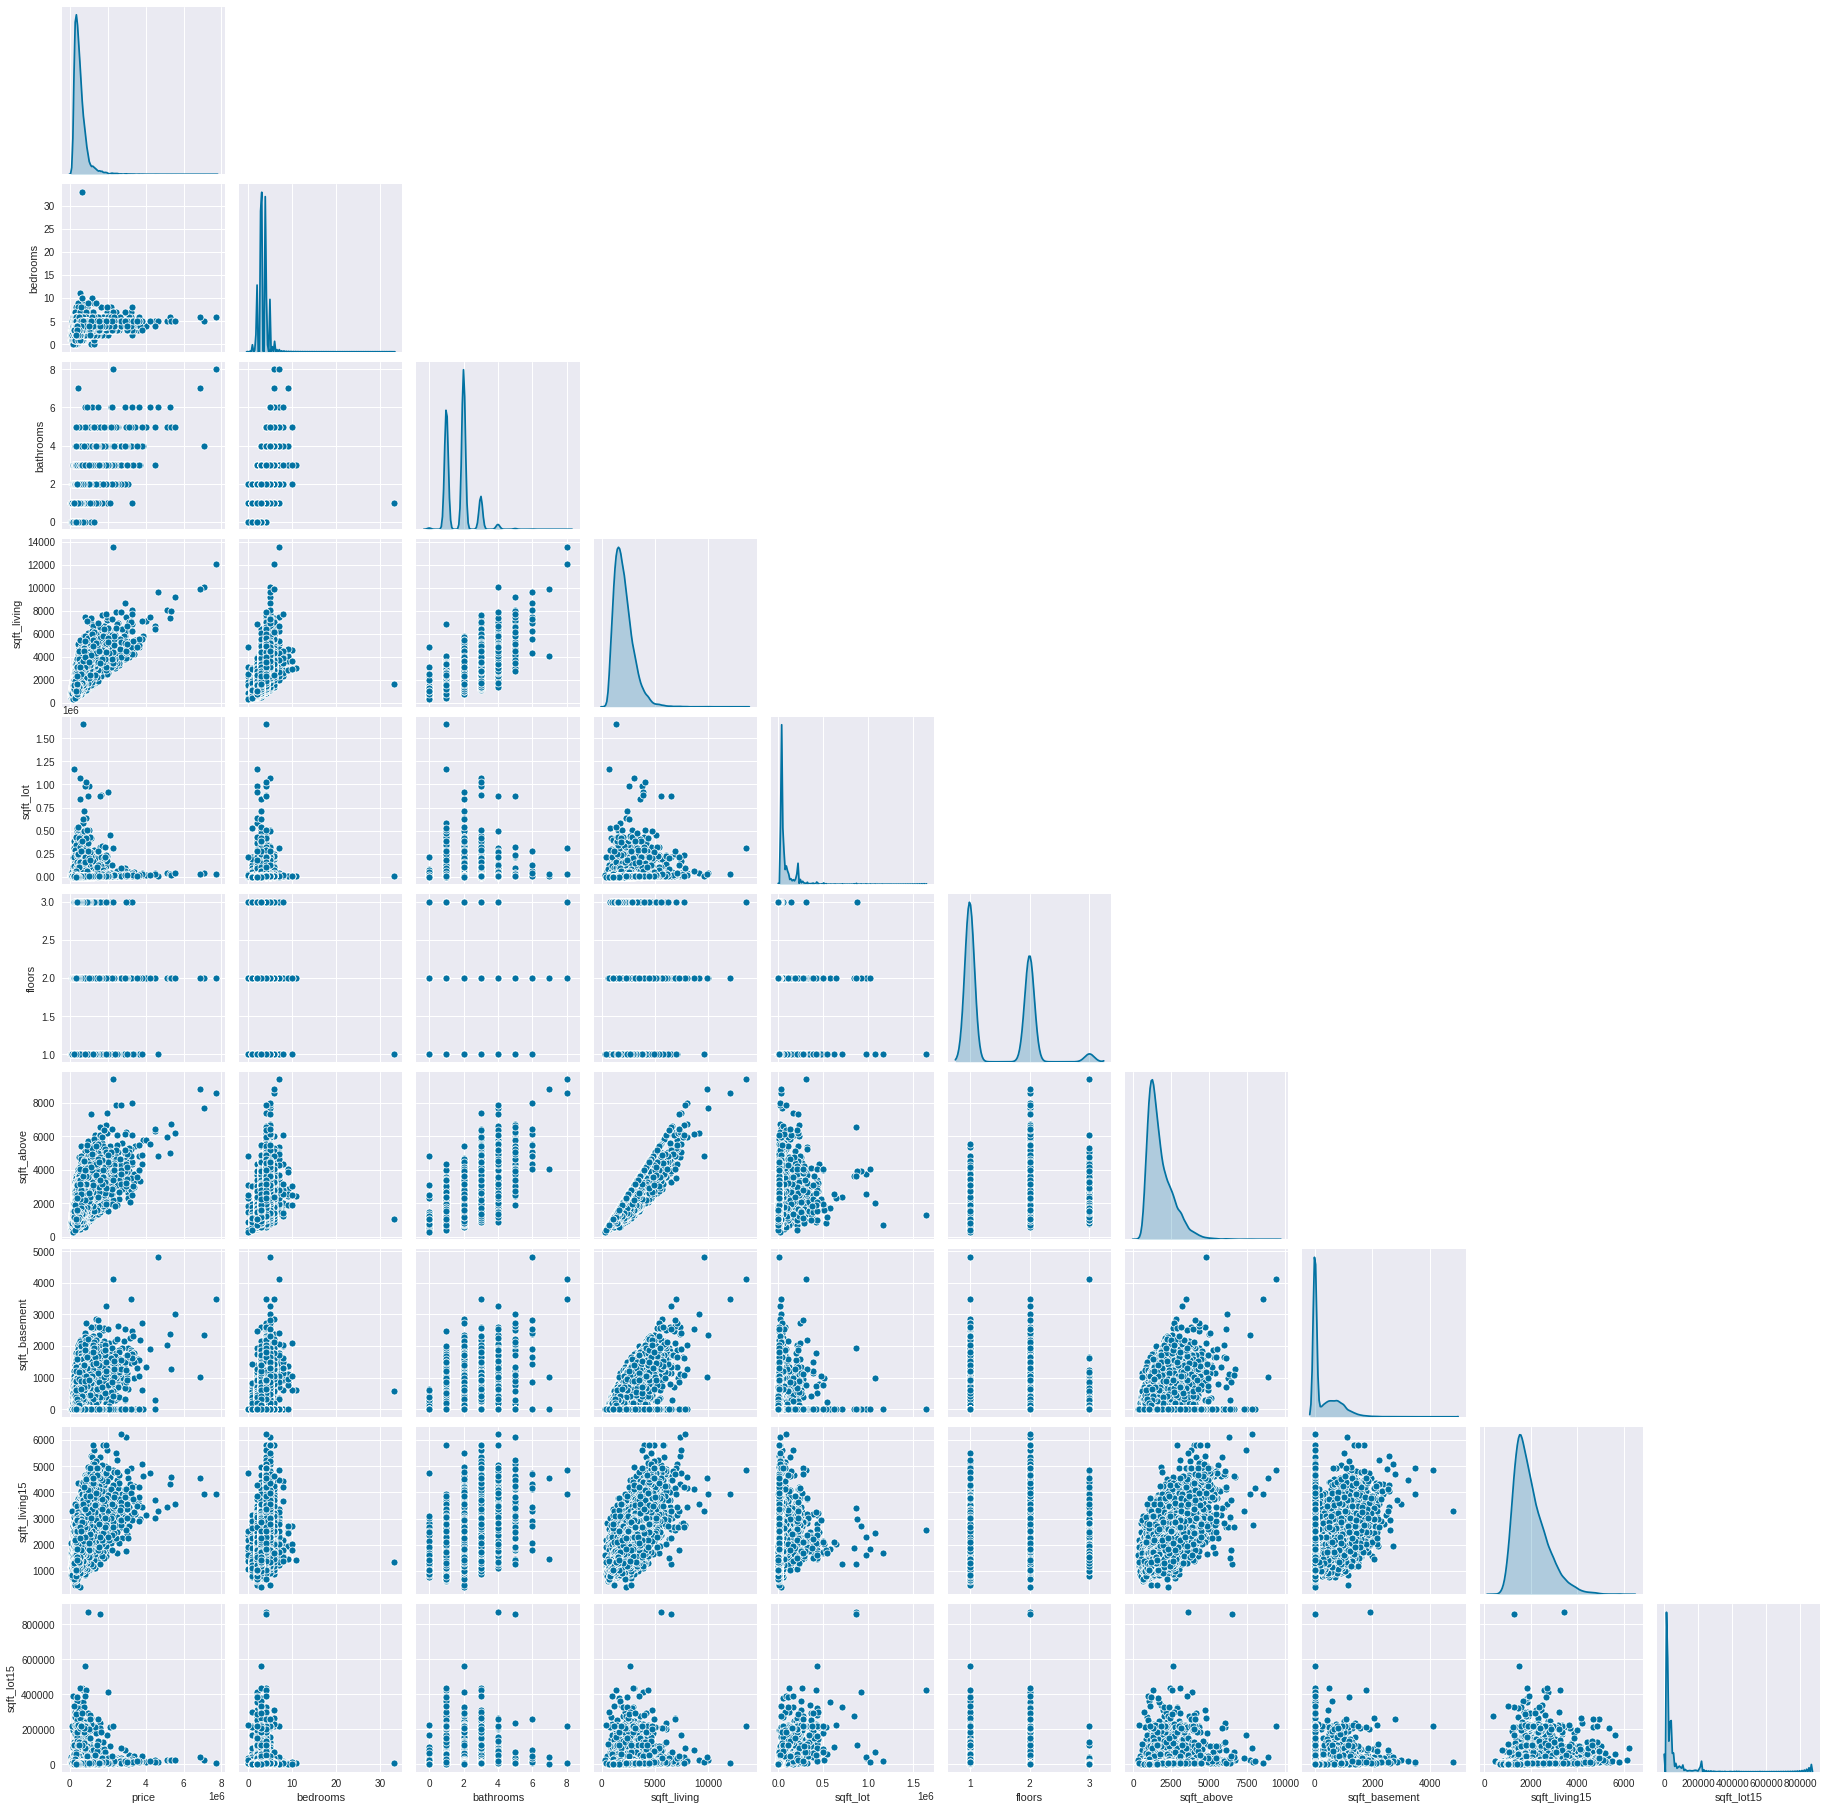

In [36]:
# Vamos plotar um pairplot com as variáveis quantitativas e entender o relacionamento entre elas e a nossa 
# variável alvo, `price`
sns.pairplot(df[var_quantitativa], diag_kind='kde', corner=True)
plt.show()

Algumas variáveis apresentarem certa relação com a variável target. No entanto, ainda precisamos aplicar as transformações nessas variáveis para entender o tipo do relacionamento(linear, exponencial, etc.).

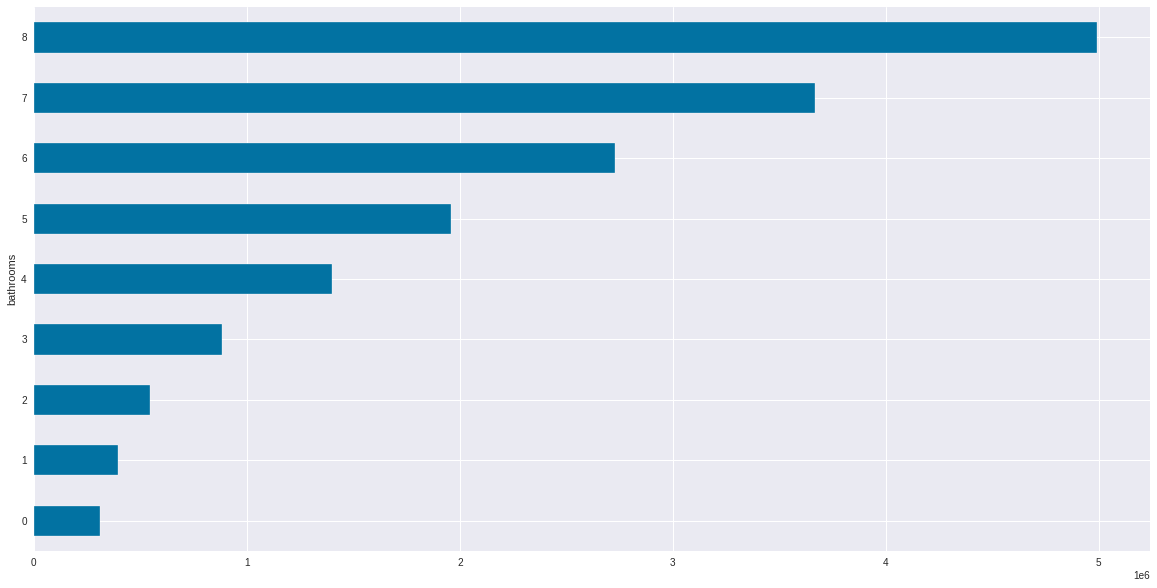

In [37]:
# Média de preços das casas por quantidade de banheiros:
df.groupby('bathrooms')['price'].mean().sort_values().plot(kind='barh')

Neste gráfico podemos observar que casas que têm mais banheiros apresentaram um preço médio maior.

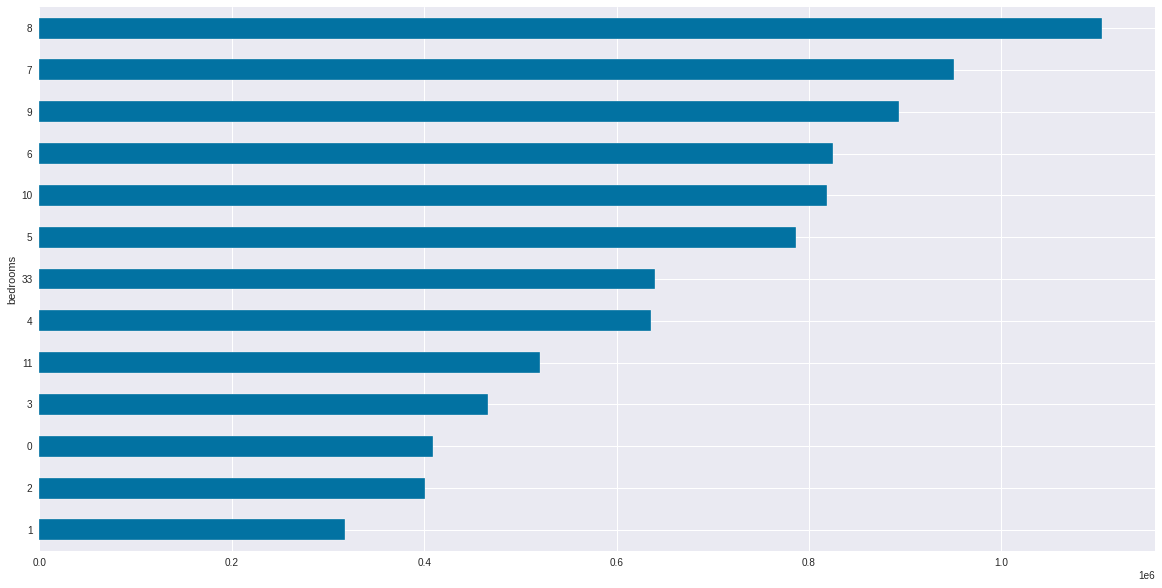

In [38]:
# Média de preços das casas por quantidade de quartos:
df.groupby('bedrooms')['price'].mean().sort_values().plot(kind='barh')

Casas que têm 8 quartos apresentaram um preço médio maior. No entanto, outras casas com maiores quantidades de quartos não apresentaram a maior média de preços. 

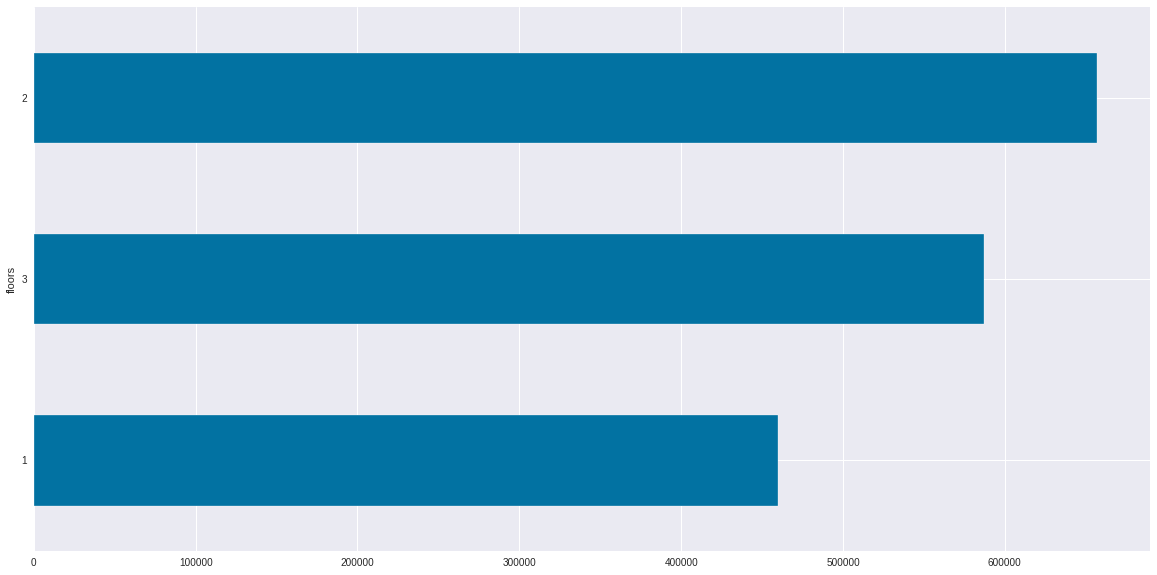

In [39]:
# Média de preços das casas por quantidade de pisos:
df.groupby('floors')['price'].mean().sort_values().plot(kind='barh')

Casas com dois pisos apresentaram a média de preços maior em relação a casas com três e um piso.

Vale ressaltar que essas análises foram feitas com média aritmética. 
Abaixo, podemos conferir a quantidade de cadas por cada variável e suas categorias.

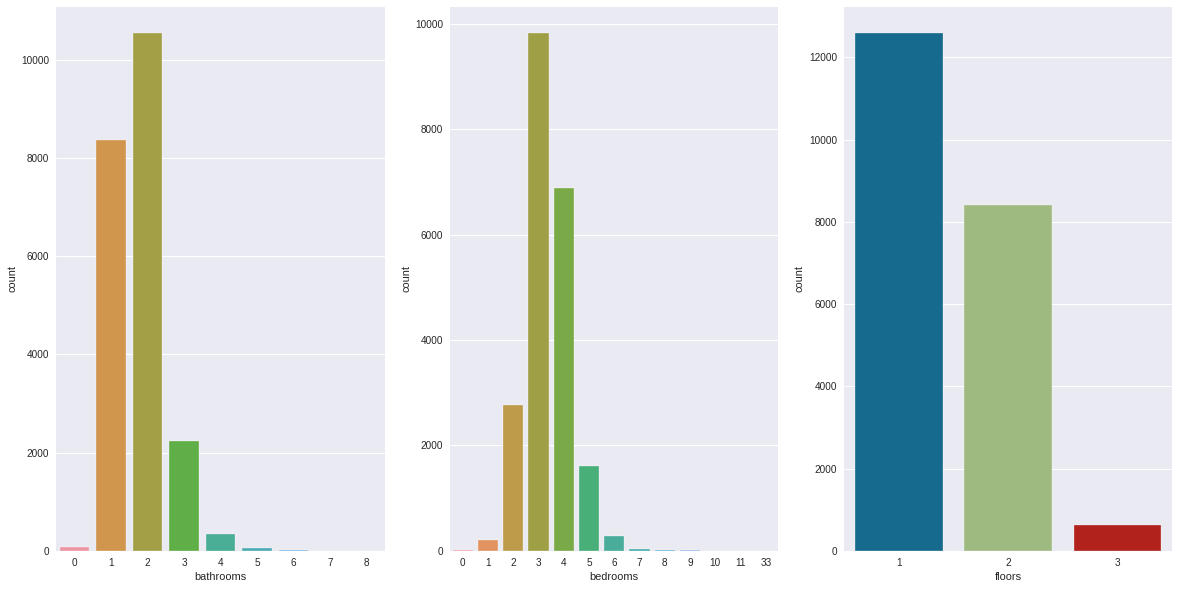

In [40]:
# Contagem da quantidade de casas por cada quantidade de banheiros, quartos e pisos. 
plt.subplot(1,3,1)
sns.countplot(x='bathrooms', data=df)

plt.subplot(1,3,2)
sns.countplot(x='bedrooms', data=df)

plt.subplot(1,3,3)
sns.countplot(x='floors', data=df)

plt.show()

Possuem mais casas com um e dois banheiros, com dois a quatro quartos, e a maioria com um piso e dois pisos.

# Feature Engineering

Esta etapa consite na criação de novas variáveis para colaborar com a criação do modelo para obtermos os melhores resultados nas previsões.

In [41]:
# Criando novas variáveis
# Valor do metro quadrado do lote

df['price_lot_m2'] = (df['price']) / (df['sqft_lot'])

# Valor do metro quadrado da casa
df['price_living_m2'] = (df['price']) / (df['sqft_living'])

# Área construída
df['area_construida'] = (df['sqft_living']) / (df['sqft_lot'])
                                             
# Preço por quantidade de cômodos
df['price_comodo'] = (df['price'])/(df['bedrooms']) + (df['bathrooms'])

# Preço por quantidade de pisos
df['price_floors'] = (df['price']) / (df['floors'])

# Raíz quadrada do tamanho do apartamento
df['living_sqrt'] = df['sqft_living'].apply(sqrt)

# Número de quartos ao quadrado
df['rooms_square'] = (df['bedrooms'] * df['bedrooms'])

In [42]:
# Selecionando as novas variáveis
new_vars = ['price_lot_m2','price_living_m2', 
            'area_construida', 'price_comodo', 
            'price_floors', 'living_sqrt', 'rooms_square']

In [43]:
# Verificando as primeiras linhas das novas variáveis
df[new_vars].head()

,price_lot_m2,price_living_m2,area_construida,price_comodo,price_floors,living_sqrt,rooms_square
0,39.274336,188.050847,0.208850,73967.666667,221900.0,34.351128,9
1,74.288870,209.338521,0.354874,179335.333333,269000.0,50.695167,9
2,18.000000,233.766234,0.077000,90001.000000,180000.0,27.748874,4
3,120.800000,308.163265,0.392000,151003.000000,604000.0,44.271887,16
4,63.118812,303.571429,0.207921,170002.000000,510000.0,40.987803,9


In [44]:
# Verificando as estatísticas das primeiras linhas
df[new_vars].describe()

,price_lot_m2,price_living_m2,area_construida,price_comodo,price_floors,living_sqrt,rooms_square
count,21613.000000,21613.000000,21613.000000,2.161300e+04,2.161300e+04,21613.000000,21613.000000
mean,88.966710,264.156594,0.323745,inf,4.011833e+05,44.596878,12.227548
std,94.055247,110.060793,0.268565,NaN,2.624940e+05,9.540568,9.946235
min,0.163119,87.588235,0.000610,1.939494e+04,4.500000e+04,17.029386,0.000000
25%,33.333333,182.291667,0.156581,9.974050e+04,2.350000e+05,37.775654,9.000000
50%,59.223301,244.644550,0.247664,1.421270e+05,3.400000e+05,43.703547,9.000000
75%,107.594937,318.322981,0.407547,1.985010e+05,4.900000e+05,50.497525,16.000000
max,2027.208539,810.138889,4.653846,inf,4.668000e+06,116.361506,1089.000000


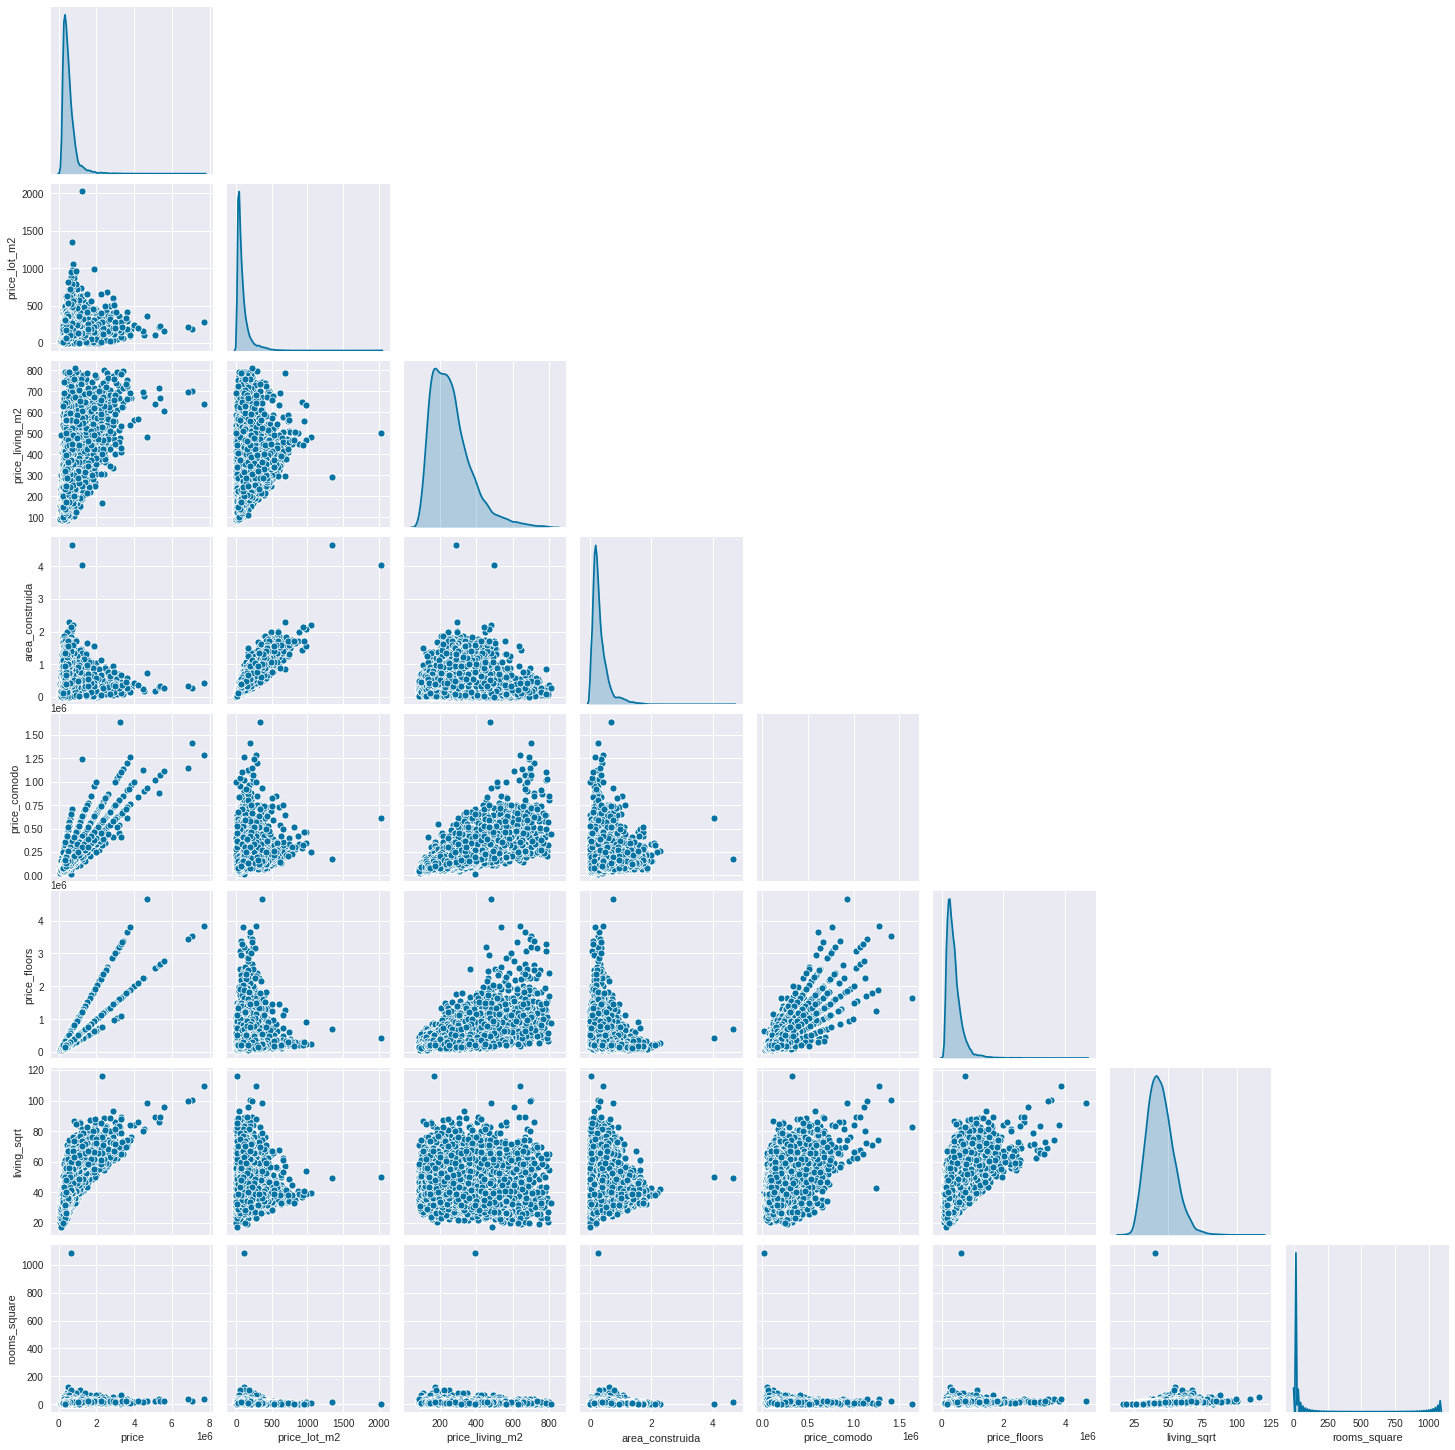

In [45]:
# Vamos plotar um pairplot com as novas variáveis  entender o relacionamento entre elas e a nossa 
# variável alvo, price
sns.pairplot(df, vars=['price','price_lot_m2','price_living_m2', 
            'area_construida', 'price_comodo', 
            'price_floors', 'living_sqrt', 'rooms_square'], 
             diag_kind='kde', 
             corner=True)
plt.show()

Pelo gráfico acima notamos que as novas variáveis também apresentaram certa relação com a nossa variável target.
Vamos plotar agora um mapa de calor e entender a correlação de pearson entre todas as variáveis quantitativas.

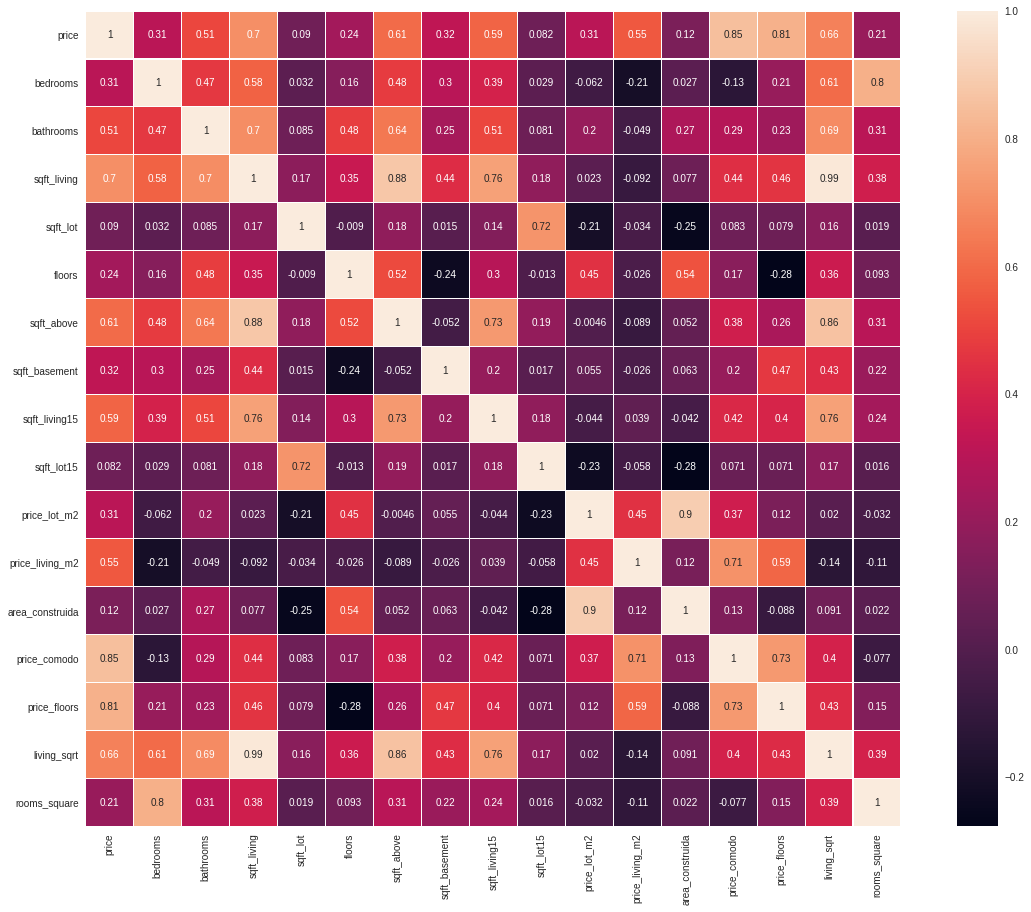

In [46]:
quantitative_vars = ['price', 'bedrooms', 
                    'bathrooms','sqft_living', 
                    'sqft_lot','floors',
                    'sqft_above','sqft_basement',
                    'sqft_living15','sqft_lot15',
                    'price_lot_m2','price_living_m2', 
                    'area_construida', 'price_comodo', 
                    'price_floors', 'living_sqrt', 'rooms_square']

plt.figure(figsize=(20, 15))
sns.heatmap(df[quantitative_vars].corr(method='pearson'), annot=True, linewidths=0.3, square=True)
plt.show()

Com os boxplots abaixo das novas variáveis, vamos verificar a existência de outliers que na próxima sessão iremos tratá-los.

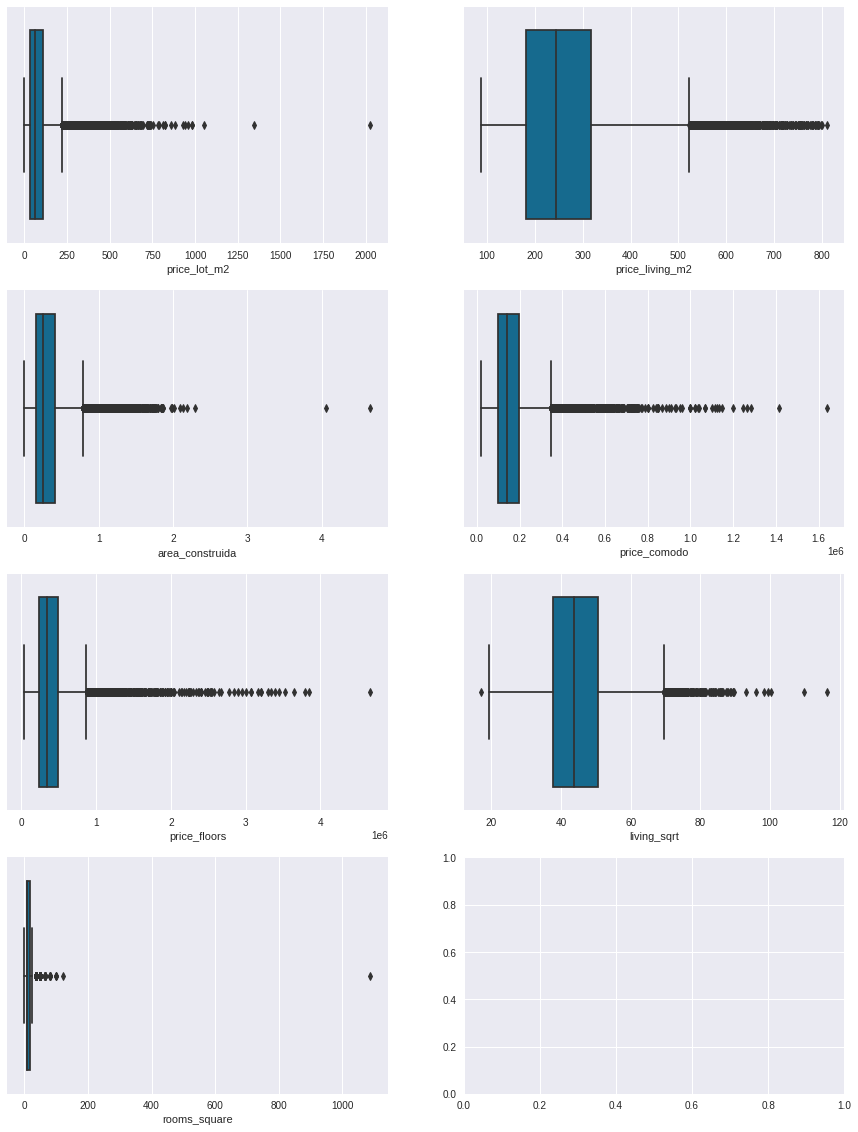

In [47]:
# Boxplot das novas variáveis quantitativas. 

fig, axes = plt.subplots(4,2, figsize=(15,20))
axes = axes.flatten()

for ax, catplot in zip(axes, df[new_vars]):
    sns.boxplot(x=catplot, ax=ax, data=df)
plt.show()

Como podemos observar, todas as variáveis que criamos apresentaram outiers. Na próxima sessão iremos tratá-los.

# Pre processing

Como dito anteriormente, a nossa variável target não apresenta uma distribuição normal, assim como algumas outras variáveis quantitativas. Vamos aplicar a transformação e então, vamos avaliar novamente os histogramas, QQ-Plot e o boxplot dessas variáveis após a transformação.

In [48]:
# Aplicando boxcox na variável Price
df['price_box'], lam_value = boxcox(df['price'])

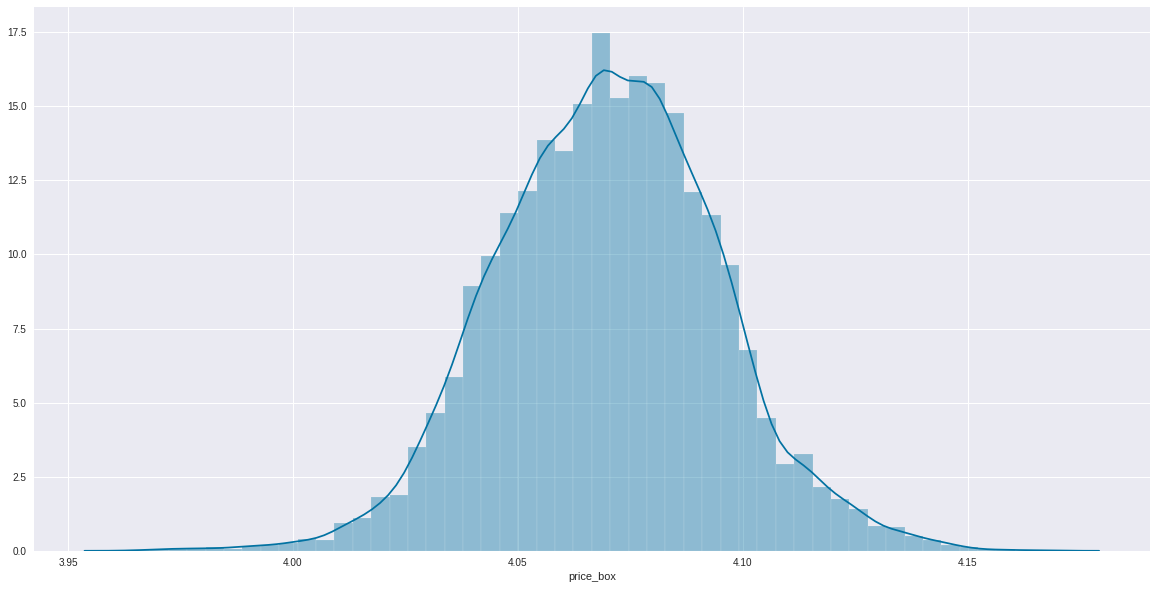

In [49]:
# Histograma dos preços das casas
sns.distplot(df['price_box'], hist=True)
plt.show()

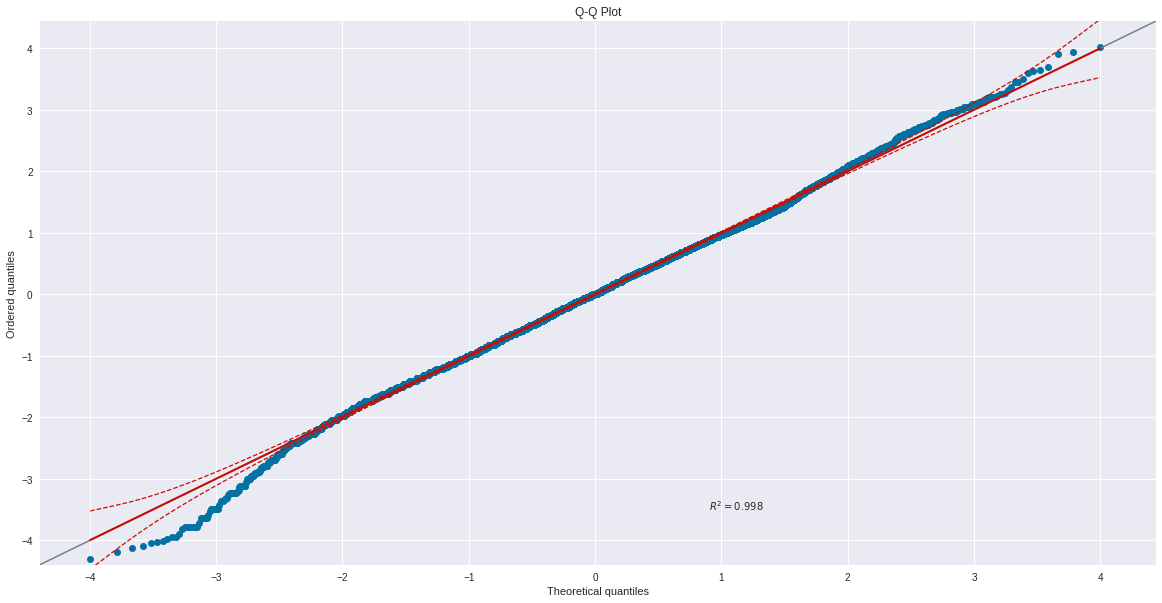

In [50]:
# Cria um Q-Q plot 
pg.qqplot(df['price_box'], dist='norm', figsize=(20,10))
plt.show()

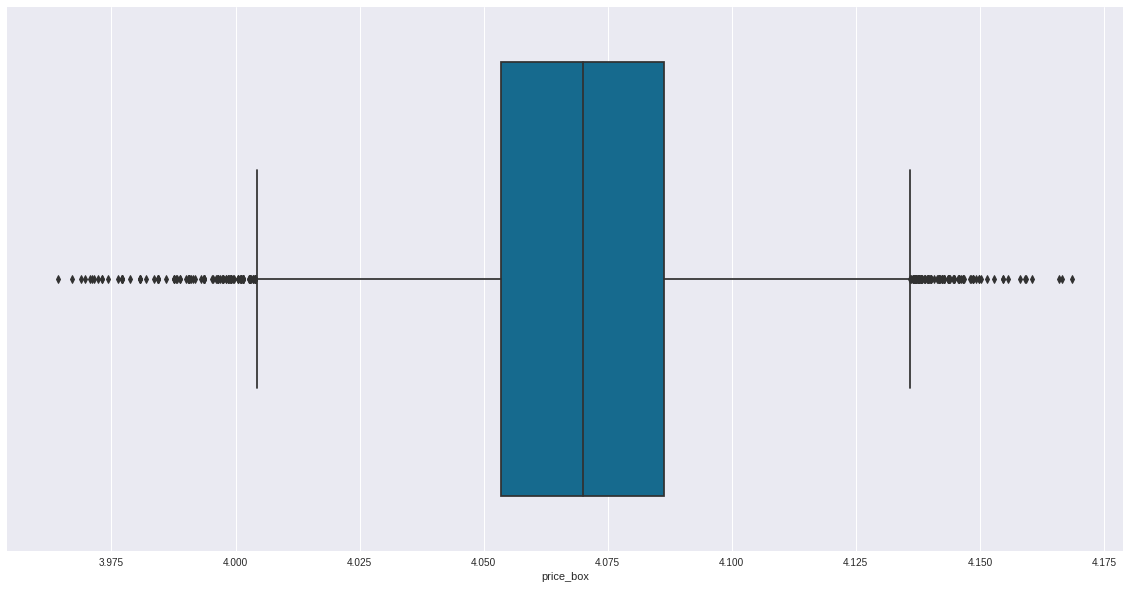

In [51]:
# Cria um boxplot
plt.figure(figsize=(20,10))
sns.boxplot(y='price_box', orient= 'h', data=df)
plt.show()

Agora com a nossa variável target transformada, vamos tratar os outliers das demais variáveis quantitativas que identificamos anteriormente. 

In [52]:
# Selecionando o 95º quantil das variáveis
upper_quantiles = df[['bedrooms','bathrooms',
                      'sqft_living','sqft_lot',
                      'sqft_above','sqft_basement',
                      'sqft_living15','sqft_lot15',
                      'price_lot_m2','price_living_m2', 
                      'area_construida', 'price_comodo', 
                      'price_floors', 'living_sqrt', 'rooms_square']].quantile(.95)
upper_quantiles

bedrooms                5.000000
bathrooms               3.000000
sqft_living          3760.000000
sqft_lot            43339.200000
sqft_above           3400.000000
sqft_basement        1190.000000
sqft_living15        3300.000000
sqft_lot15          37062.800000
price_lot_m2          281.538351
price_living_m2       472.729889
area_construida         0.891354
price_comodo       333335.333333
price_floors       840000.000000
living_sqrt            61.318839
rooms_square           25.000000
Name: 0.95, dtype: float64

In [53]:
# Selecionando os dados que são maiores que o 95º quantil
outliers = (df[['bedrooms','bathrooms',
                'sqft_living','sqft_lot',
                'sqft_above','sqft_basement',
                'sqft_living15','sqft_lot15',
                'price_lot_m2','price_living_m2', 
                'area_construida', 'price_comodo', 
                'price_floors', 'living_sqrt', 'rooms_square']] > upper_quantiles)

# Seleciona as colunas com outliers
outliers_vars = ['bedrooms','bathrooms',
                'sqft_living','sqft_lot',
                'sqft_above','sqft_basement',
                'sqft_living15','sqft_lot15',
                'price_lot_m2','price_living_m2', 
                'area_construida', 'price_comodo', 
                'price_floors', 'living_sqrt', 'rooms_square']

# Substituindo os outliers pelo 95º quantil de cada variável
for i in outliers:
    df[outliers_vars] = df[outliers_vars].mask(outliers, upper_quantiles, axis=1)

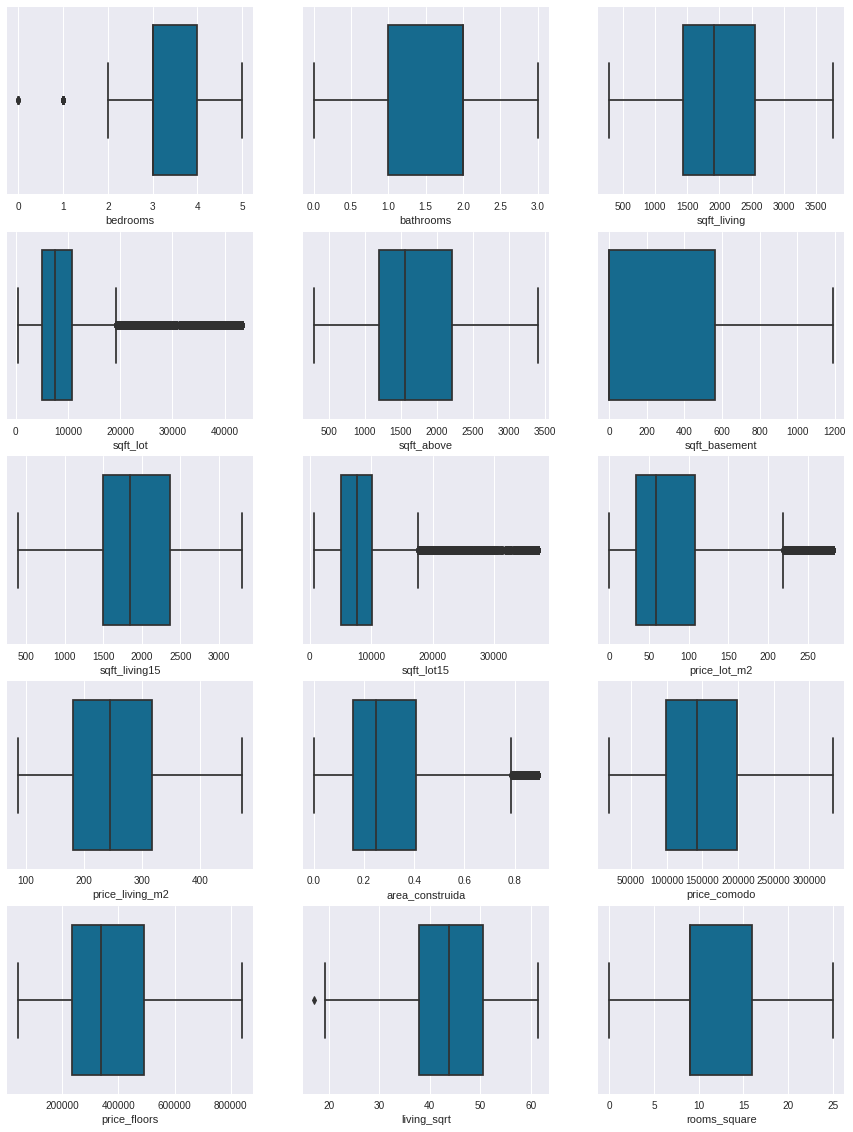

In [54]:
# Plotar o boxplot das variáveis quantitativas após tratar os outliers.

fig, axes = plt.subplots(5,3, figsize=(15,20))
axes = axes.flatten()


for ax, catplot in zip(axes, df[outliers_vars]):
    sns.boxplot(x=catplot, ax=ax, data=df)
plt.show()

Algumas variáveis ainda continuam com outliers e vamos mante-las dessa maneira. 

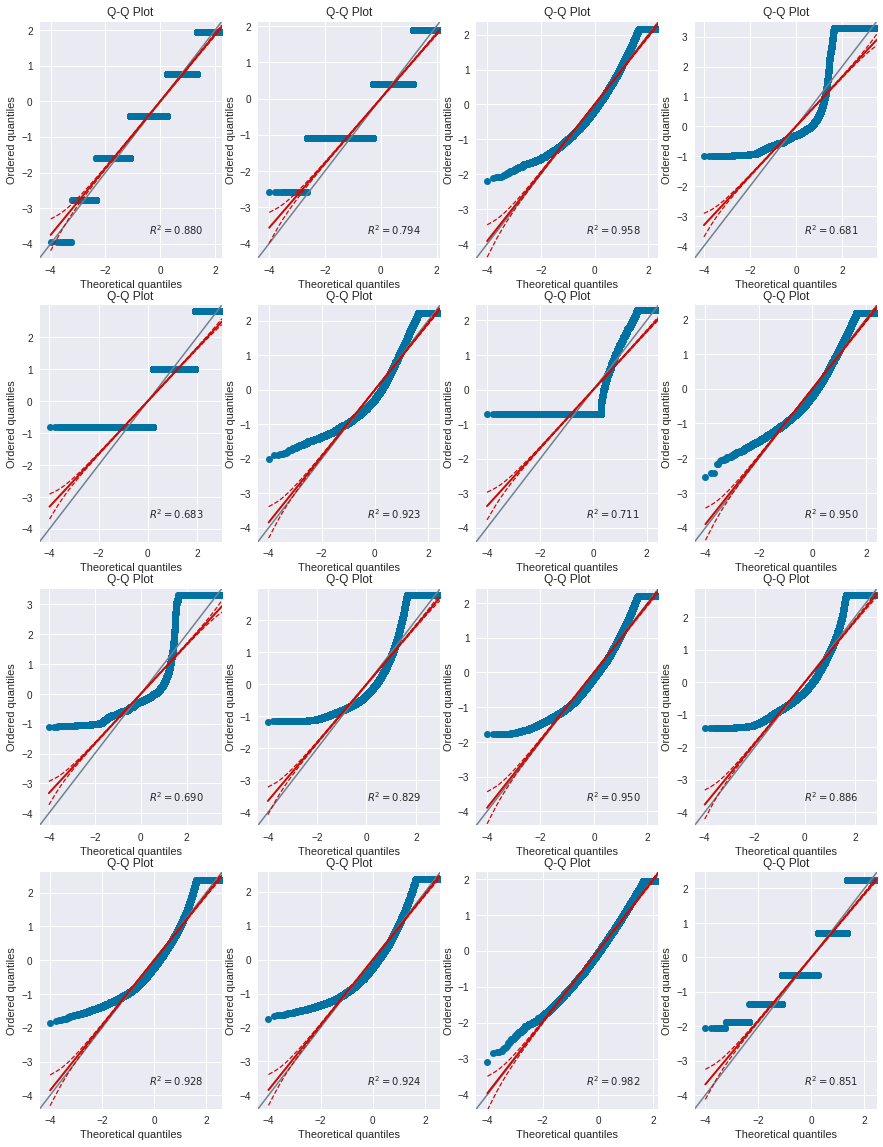

In [55]:
# PLotar o QQ-Plot das variáveis quantitativas
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(15,20) )

ax1 = pg.qqplot(df['bedrooms'], dist='norm', ax=ax1)
ax2 = pg.qqplot(df['bathrooms'], dist='norm', ax=ax2)
ax3 = pg.qqplot(df['sqft_living'], dist='norm', ax=ax3)
ax4 = pg.qqplot(df['sqft_lot'], dist='norm', ax=ax4)
ax5 = pg.qqplot(df['floors'], dist='norm', ax=ax5)
ax6 = pg.qqplot(df['sqft_above'], dist='norm', ax=ax6)
ax7 = pg.qqplot(df['sqft_basement'], dist='norm', ax=ax7)
ax8 = pg.qqplot(df['sqft_living15'], dist='norm', ax=ax8)
ax9 = pg.qqplot(df['sqft_lot15'], dist='norm', ax=ax9)
ax10 = pg.qqplot(df['price_lot_m2'], dist='norm', ax=ax10)
ax11 = pg.qqplot(df['price_living_m2'], dist='norm', ax=ax11)
ax12 = pg.qqplot(df['area_construida'], dist='norm', ax=ax12)
ax13 = pg.qqplot(df['price_comodo'], dist='norm', ax=ax13)
ax14 = pg.qqplot(df['price_floors'], dist='norm', ax=ax14)
ax15 = pg.qqplot(df['living_sqrt'], dist='norm', ax=ax15)
ax16 = pg.qqplot(df['rooms_square'], dist='norm', ax=ax16)

plt.show()

In [56]:
# Selecionando novamente as variáveis quantitativas (e as novas variáveis), 
# exceto o preço para aplicar as transformações
quant_vars = ['bedrooms','bathrooms',
              'sqft_living','sqft_lot','floors',
              'sqft_above','sqft_basement',
              'sqft_living15','sqft_lot15',
              'price_lot_m2','price_living_m2', 
              'area_construida', 'price_comodo', 
              'price_floors', 'living_sqrt', 'rooms_square']

In [57]:
# Aplicando as transformações aos dados e criando um novo dataset
# Cria um pipeline com powwer_transformer e min_max_scaler
pipeline = Pipeline([('power_transform', PowerTransformer(standardize=False)), 
                     ('min_max_scaler', MinMaxScaler())])

# Realiza as transformações
quant_scaler = pd.DataFrame(pipeline.fit_transform(df[quant_vars]), 
                            columns=quant_vars)

# Retorna as estatísticas descritivas do dataset
quant_scaler.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price_lot_m2,price_living_m2,area_construida,price_comodo,price_floors,living_sqrt,rooms_square
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,0.675675,0.666408,0.667946,0.612974,0.332191,0.714013,0.374444,0.730068,0.607629,0.621382,0.585445,0.542440,0.678639,0.665642,0.667537,0.640109
std,0.168155,0.193398,0.181708,0.175897,0.394043,0.160731,0.466573,0.148644,0.174095,0.192688,0.227020,0.238240,0.172336,0.182007,0.181903,0.188232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.607216,0.451241,0.537241,0.518194,0.000000,0.595602,0.000000,0.622728,0.512277,0.494777,0.412560,0.375414,0.550879,0.533264,0.536661,0.563940
50%,0.607216,0.759149,0.663743,0.611396,0.000000,0.702926,0.000000,0.722740,0.611494,0.610974,0.587622,0.525513,0.678719,0.663306,0.663301,0.563940
75%,0.804396,0.759149,0.799582,0.687544,0.780605,0.837868,0.950342,0.840811,0.680556,0.746488,0.748998,0.714428,0.802309,0.796163,0.799317,0.785446
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


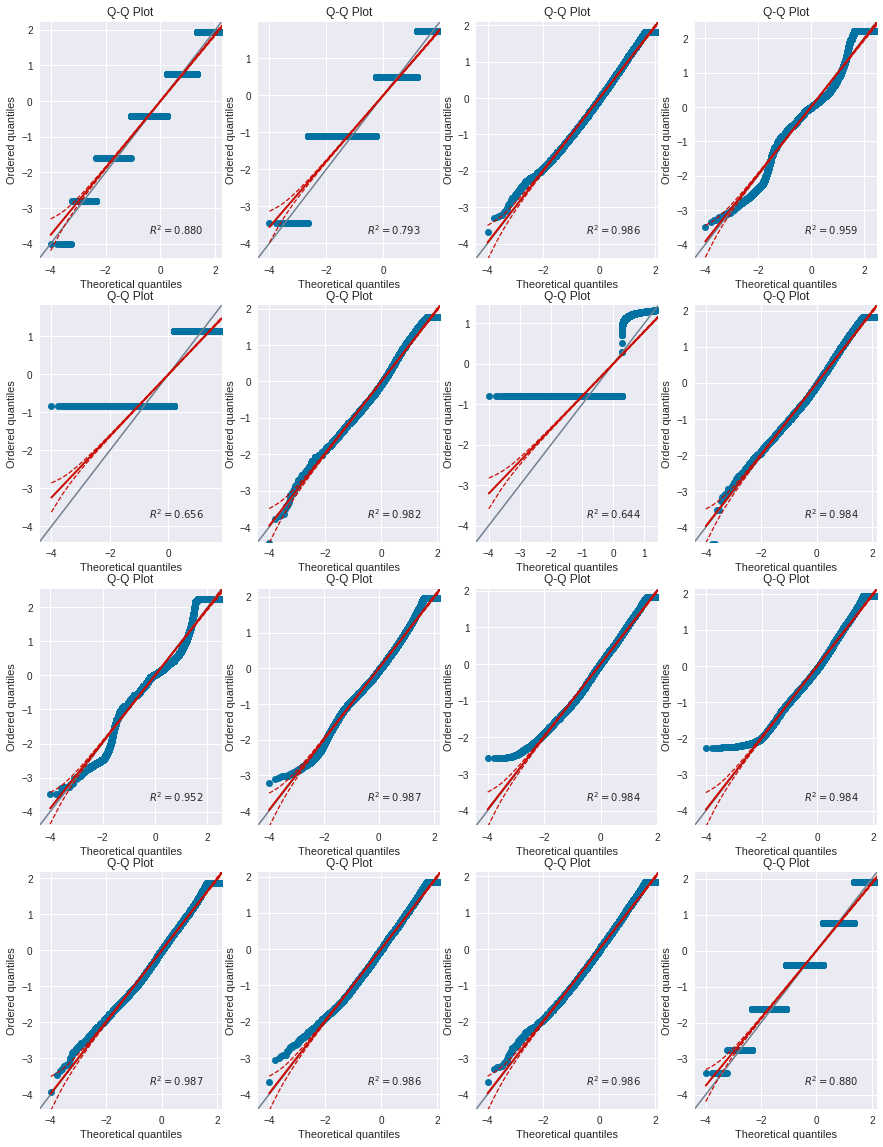

In [58]:
# QQ-Plot das variáveis já transformadas
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(15,20) )

ax1 = pg.qqplot(quant_scaler['bedrooms'], dist='norm', ax=ax1)
ax2 = pg.qqplot(quant_scaler['bathrooms'], dist='norm', ax=ax2)
ax3 = pg.qqplot(quant_scaler['sqft_living'], dist='norm', ax=ax3)
ax4 = pg.qqplot(quant_scaler['sqft_lot'], dist='norm', ax=ax4)
ax5 = pg.qqplot(quant_scaler['floors'], dist='norm', ax=ax5)
ax6 = pg.qqplot(quant_scaler['sqft_above'], dist='norm', ax=ax6)
ax7 = pg.qqplot(quant_scaler['sqft_basement'], dist='norm', ax=ax7)
ax8 = pg.qqplot(quant_scaler['sqft_living15'], dist='norm', ax=ax8)
ax9 = pg.qqplot(quant_scaler['sqft_lot15'], dist='norm', ax=ax9)
ax10 = pg.qqplot(quant_scaler['price_lot_m2'], dist='norm', ax=ax10)
ax11 = pg.qqplot(quant_scaler['price_living_m2'], dist='norm', ax=ax11)
ax12 = pg.qqplot(quant_scaler['area_construida'], dist='norm', ax=ax12)
ax13 = pg.qqplot(quant_scaler['price_comodo'], dist='norm', ax=ax13)
ax14 = pg.qqplot(quant_scaler['price_floors'], dist='norm', ax=ax14)
ax15 = pg.qqplot(quant_scaler['living_sqrt'], dist='norm', ax=ax15)
ax16 = pg.qqplot(quant_scaler['rooms_square'], dist='norm', ax=ax16)

plt.show()

In [59]:
# Transfromar as variáveis categóricas em dummys
cat_vars = ['waterfront', 'view', 'condition', 'grade', 'decada_built']

dummies = pd.get_dummies(df[cat_vars])

dummies.head()

,waterfront_NO,waterfront_YES,view_NO,view_YES,condition_BAD,condition_GOOD,condition_REGULAR,grade_BAD,grade_GOOD,grade_REGULAR,...,decada_built_dec_built1920,decada_built_dec_built1930,decada_built_dec_built1940,decada_built_dec_built1950,decada_built_dec_built1960,decada_built_dec_built1970,decada_built_dec_built1980,decada_built_dec_built1990,decada_built_dec_built2000,decada_built_dec_built2010
0,1,0,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,0,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,0,1,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [60]:
# Unir os datasets
frames = [quant_scaler, dummies, df['price']]

df_trasnform_1 = pd.concat(frames, axis=1)

df_trasnform_1.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price_lot_m2,...,decada_built_dec_built1930,decada_built_dec_built1940,decada_built_dec_built1950,decada_built_dec_built1960,decada_built_dec_built1970,decada_built_dec_built1980,decada_built_dec_built1990,decada_built_dec_built2000,decada_built_dec_built2010,price
0,0.607216,0.451241,0.460078,0.544003,0.000000,0.592222,0.000000,0.572460,0.537606,0.526568,...,0,0,1,0,0,0,0,0,0,221900.0
1,0.607216,0.759149,0.803406,0.599994,0.780605,0.830878,0.925511,0.682423,0.612109,0.660576,...,0,0,1,0,0,0,0,0,0,538000.0
2,0.408040,0.451241,0.300827,0.672598,0.000000,0.418468,0.000000,0.908201,0.625407,0.384726,...,1,0,0,0,0,0,0,0,0,180000.0
3,0.804396,1.000000,0.675454,0.516393,0.000000,0.545254,0.983222,0.579477,0.507378,0.774615,...,0,0,0,1,0,0,0,0,0,604000.0
4,0.607216,0.759149,0.606812,0.624653,0.000000,0.731930,0.000000,0.712319,0.607675,0.624694,...,0,0,0,0,0,1,0,0,0,510000.0


In [61]:
# Separa as variáveis preditoras da variável target
X = df_trasnform_1.drop('price', axis=1)
y = df_trasnform_1['price']

# Divide o conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Models

Vamos criar uma lista com os algoritmos, identificar o melhor, otimizá-lo e fazer as previsões.

Lasso Regression: -25807162491.005527 (9013719476.527699)
Ridge Regression: -25847790274.164589 (9389271662.667557)
Hubber Regression: -36238270159.009499 (14469320884.649593)
Random Sample Consensus: -41833840043.265976 (15489290593.600994)
Theil-Sen Estimator: -30635073062.070396 (12085739377.727036)
Decision Tree Regressor: -8091627775.794909 (3826115294.511127)
Random Forest Regressor: -4694955055.495584 (3520370065.290732)
XGBoost Regressor: -3269012079.892470 (2439961239.930668)
Light Gradient Boosting Regressor: -3248524636.171834 (2485460127.528791)


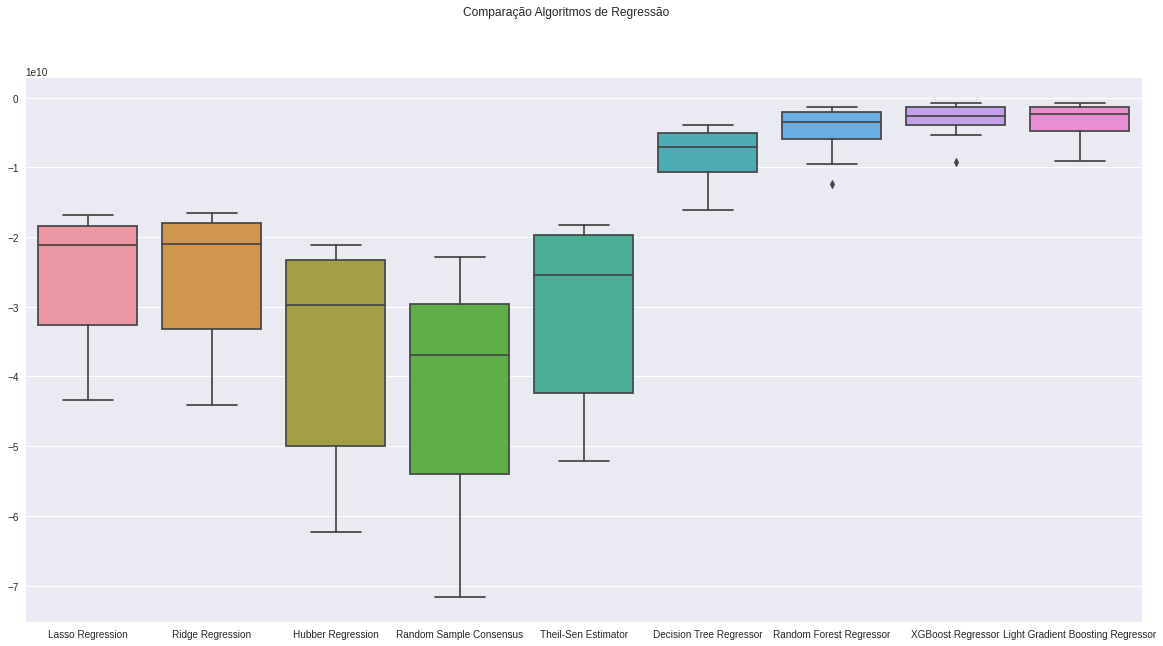

In [62]:
# Instanciando e criando uma lista com os algoritmos
modelos = []
modelos.append(('Lasso Regression', Lasso(random_state=42)))
modelos.append(('Ridge Regression', Ridge(random_state=42)))
modelos.append(('Hubber Regression', HuberRegressor()))
modelos.append(('Random Sample Consensus', RANSACRegressor(random_state=42)))
modelos.append(('Theil-Sen Estimator', TheilSenRegressor(random_state=42)))
modelos.append(('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)))
modelos.append(('Random Forest Regressor', RandomForestRegressor(random_state=42)))
modelos.append(('XGBoost Regressor', XGBRegressor(random_state=42)))
modelos.append(('Light Gradient Boosting Regressor', LGBMRegressor(random_state=42)))

# Lista de resultados e nomes dos modelos
resultados = []
nomes = []

# Seleção do melhor modelo por meio de uma validação cruzada
for nome, modelo in modelos:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(modelo, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Box-plot dos modelos
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparação Algoritmos de Regressão')
ax = fig.add_subplot(111)
sns.boxplot(x=nomes, y=resultados)
ax.set_xticklabels(nomes)
plt.show()

O modelo que apresentou o melhor desempenho no primeiro treinamento foi o ***Light Gradient Boosting Regressor***. 
A próxima etapa é a otimização dos parâmetros, mas antes de otimizar, vamos treinar um modelo base sem modifcar os parâmetros e ver como o modelo se comporta.

In [63]:
# Modelo base do LGBMRegressor
lgmb_reg_base = LGBMRegressor(random_state=42)

# Treinando o modelo
lgmb_reg_base.fit(X_train, y_train)



LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

A seguir, vamos avaliar os seguintes plots de todos os modelos treinados, são eles:


* **Gráfico dos resíduos/ResidualsPlot**: Os resíduos, no contexto dos modelos de regressão, são a diferença entre o valor observado da variável alvo (y) e o valor previsto (ŷ), ou seja, o erro da previsão. 
* **Gráfico de erro de previsão/PredictionError**:Um gráfico de erro de previsão mostra os destinos reais do conjunto de dados em relação aos valores previstos gerados pelo nosso modelo. Isso nos permite ver quanta variação há no modelo.
* **Curva de Aprendizado/LearingCurve**: Uma curva de aprendizado mostra a relação da pontuação do treinamento versus a pontuação do teste validado cruzado para um estimador com um número variável de amostras de treinamento. 

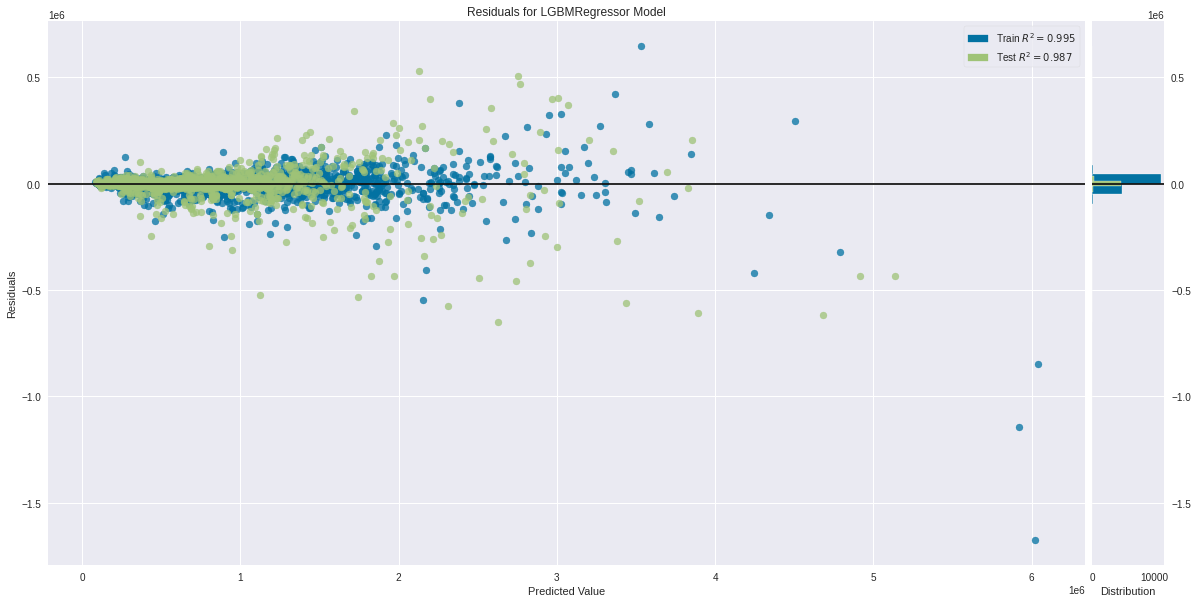

In [64]:
# Gráfico dos resíduos
# Instanciando o modelo e visualizando os resíduos
visualizer = ResidualsPlot(lgmb_reg_base)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  
visualizer.show()                 

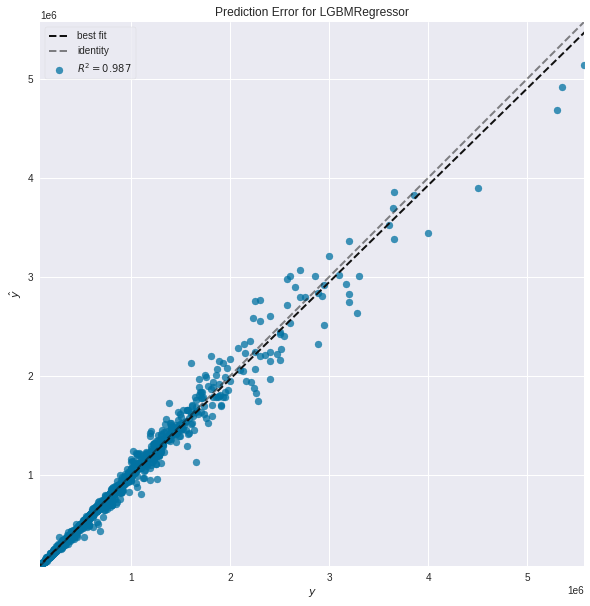

In [65]:
# Gráfico de erro de previsão
# Instanciando o modelo e visualizando dos erros das previsões
visualizer = PredictionError(lgmb_reg_base)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  
visualizer.show()

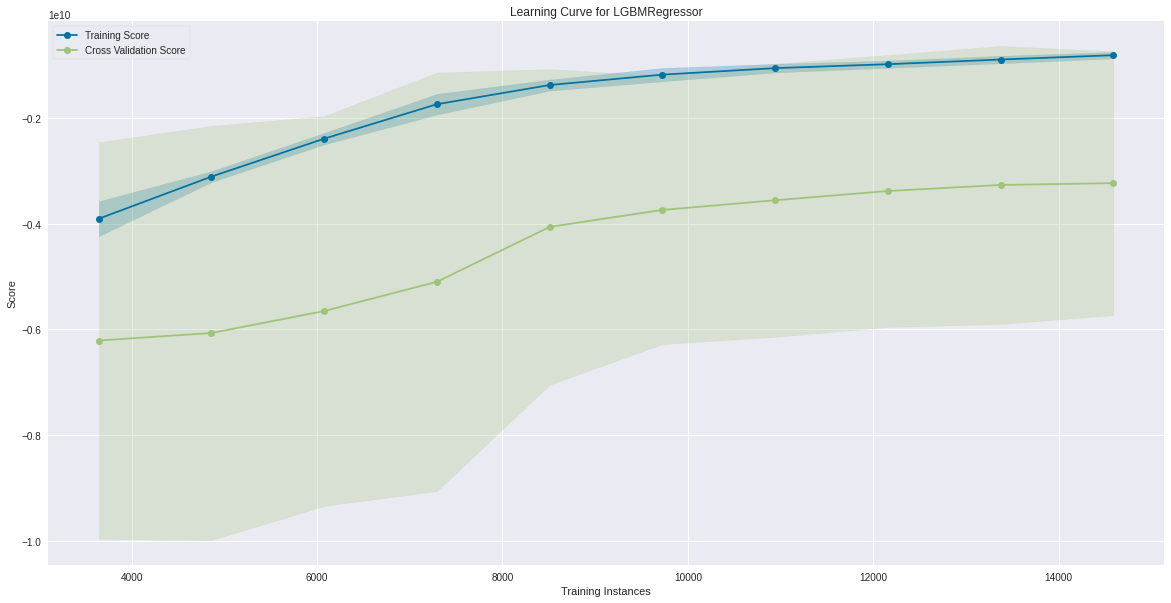

In [66]:
# Curva de Aprendizado
# Instanciando o modelo e visualizando a curva de aprendizado.
model = lgmb_reg_base
cv = KFold(n_splits=10, random_state=42)
sizes = np.linspace(0.25, 1, 10)

visualizer = LearningCurve(model,cv=cv, train_sizes=sizes, scoring='neg_mean_squared_error')

visualizer.fit(X_train, y_train)        
visualizer.show()           

In [67]:
# Realizando predições
pred_base=lgmb_reg_base.predict(X_test)

In [68]:
# Visualizando as métricas
print('O valor do MSE score é:', mean_squared_error(y_test, pred_base))
print('O valor do RMSE score é:', np.sqrt(mean_squared_error(y_test, pred_base)))
print('O valor do MAE score é:', mean_absolute_error(y_test, pred_base))

O valor do MSE score é: 1891387360.3867886
O valor do RMSE score é: 43490.08347183055
O valor do MAE score é: 12860.445629925616


# Optimization

A seguir, será passado uma lista de parâmetros ao algoritmo para testar, e assim obter os melhores parâmetros que otimizara o modelo. 

In [69]:
# Instanciando o modelo
lgbm_reg = LGBMRegressor(random_state=42)

# A lista de hiperparâmetros que queremos otimizar. 
space  = [Real(1e-5, 1e-1, 'log-uniform', name='learning_rate'),
          Integer(200, 2000, name='n_estimators'),
          Integer(10, 100, name='num_leaves'),
          Integer(10, 100, name= 'max_depth'),
          Integer(0, 10, name='min_child_weight'),
          Real(0.05, 1.0, name='subsample'),
          Real(0.1, 1.0, name='colsample_bytree'),
          Real(0.00001, 0.1, name='reg_alpha'),
          Real(0.00001, 0.1, name='reg_lambda')]

# permite que sua função objetivo receba os parâmetros como argumentos de palavras-chave.
@use_named_args(space)
def objective(**params):
    lgbm_reg.set_params(**params)

    return -np.mean(cross_val_score(lgbm_reg, X_train, y_train, cv=10, n_jobs=-1, scoring="neg_mean_squared_error"))

In [70]:
# Otimização Bayesssiana poor Processos Gausssianos 
result_gp = gp_minimize(objective, # Função a ser minimizada
                        space, # Espaços dos hiperparâmetros a ser otimizado
                        n_calls=50, # Número de rodadas para otimização
                        n_random_starts=10, # Número de avaliações de pontos aleatórios antes de aproximar a função.
                        random_state=42, 
                        verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 30.1172
Function value obtained: 3645542120.2428
Current minimum: 3645542120.2428
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.0489
Function value obtained: 18409474283.6361
Current minimum: 3645542120.2428
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 23.1284
Function value obtained: 127630936345.6137
Current minimum: 3645542120.2428
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 69.7728
Function value obtained: 2633631718.2185
Current minimum: 2633631718.2185
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.1251
Function va

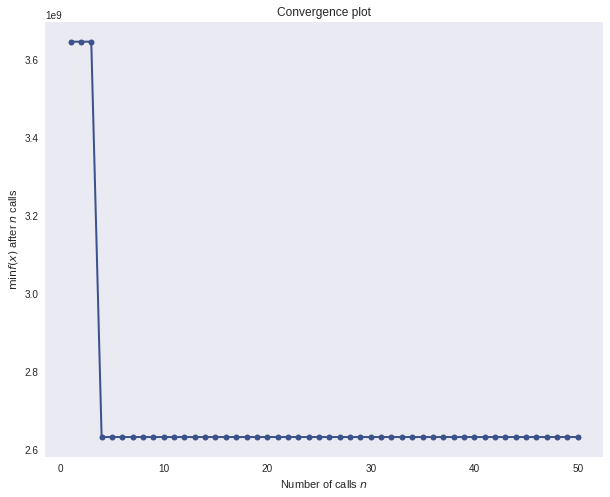

In [71]:
# Plot da convergência do Processo Gaussiano.
plt.figure(figsize=(10, 8))
plot_convergence(result_gp)

In [72]:
# Melhores hiperparâmetros 
print('Melhores parâmetros para maximização do MSE: ', result_gp.x)

Melhores parâmetros para maximização do MSE:  [0.08568869785189018, 1040, 87, 71, 5, 0.06260171310187321, 0.9479815801163677, 0.05633318890237549, 0.03854779608896623]


In [73]:
# Instanciando o modelo com os melhores parâmetros
lgbm_opt = LGBMRegressor(learning_rate=0.08568869785189018, 
                         n_estimators=1040, 
                         num_leaves=87,
                         max_depth=71,
                         min_child_weight=5,
                         subsample=0.06260171310187321,
                         colsample_bytree=0.9479815801163677,
                         reg_alpha=0.05633318890237549,
                         reg_lambda=0.03854779608896623)
    
# Treinando o modelo com as variáveis selecionadas
lgbm_opt.fit(X_train, y_train)

# Realizando as previsões
pred_lgbm_opt = lgbm_opt.predict(X_test)

In [74]:
print('O valor do MSE score é:', mean_squared_error(y_test, pred_lgbm_opt))
print('O valor do RMSE score é:', np.sqrt(mean_squared_error(y_test, pred_lgbm_opt)))
print('O valor do MAE score é:', mean_absolute_error(y_test, pred_lgbm_opt))

O valor do MSE score é: 1773878060.0720856
O valor do RMSE score é: 42117.43178390731
O valor do MAE score é: 9885.252059560295


# Feature selection

Com os parâmetros selecionados, podemos treinar o modelo final. Mas antes, para melhorarmos ainda mais a performance do nosso modelo, vamos realizar a seleção de atributo *(feature selection)*, ou seja, selecionar as melhores variáveis para o modelo, as variáveis que reduzem o erro e tornam o modelo mais estável.

In [75]:
# Selecionando o número de features que reduzem o erro do modelo
k_vs_score = []
for k in range(2, X_train.shape[1], 2):
    selector = SelectFromModel(LGBMRegressor(learning_rate=0.08568869785189018, 
                             n_estimators=1040, 
                             num_leaves=87,
                             max_depth=71,
                             min_child_weight=5,
                             subsample=0.06260171310187321,
                             colsample_bytree=0.9479815801163677,
                             reg_alpha=0.05633318890237549,
                             reg_lambda=0.03854779608896623), max_features=k, threshold=-np.inf)
    
    # Treinando o modelo para selecionar as features
    selector.fit(X_train, y_train)
    
    # Atribuindo as features selecionadas a um novo dataset de treino e de teste
    X_train2 = pd.DataFrame(selector.transform(X_train))
    X_test2 = pd.DataFrame(selector.transform(X_test))
    
    #  Instanciando o modelo para ser treinado com os novos datasets
    mdl = LGBMRegressor(learning_rate=0.08568869785189018, 
                             n_estimators=1040, 
                             num_leaves=87,
                             max_depth=71,
                             min_child_weight=5,
                             subsample=0.06260171310187321,
                             colsample_bytree=0.9479815801163677,
                             reg_alpha=0.05633318890237549,
                             reg_lambda=0.03854779608896623)
    
    # Treinando o modelo com as features
    mdl.fit(X_train2, y_train)
    
    # Obtendo as previsões
    p = mdl.predict(X_test2)
    
    # Calculando o score para cada quantidade de features e imprimindo os resultados
    score=mean_squared_error(y_test, p)                           
    print("k={} - MSE = {}".format(k, score))
    
    # Nome das variáveis selecionadas
    mask = selector.get_support()
    
    # Armazenando os scores
    k_vs_score.append(score)

k=2 - MSE = 59008262133.41238
k=4 - MSE = 35130898978.297485
k=6 - MSE = 4067442695.5901747
k=8 - MSE = 1993378620.5973363
k=10 - MSE = 1933079595.3306534
k=12 - MSE = 1660176264.7648487
k=14 - MSE = 1752049853.1115131
k=16 - MSE = 1714192059.4973981
k=18 - MSE = 1672439030.9218302
k=20 - MSE = 1702059834.3043513
k=22 - MSE = 1753059007.2149441
k=24 - MSE = 1623486420.3146017
k=26 - MSE = 1835796297.3358123
k=28 - MSE = 1852733263.1333618
k=30 - MSE = 1756184322.8854804
k=32 - MSE = 1712976561.4849787
k=34 - MSE = 1761209999.7094343
k=36 - MSE = 1816626978.389937


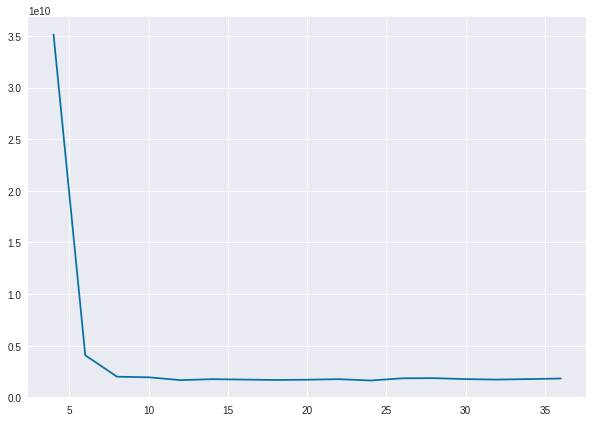

In [76]:
# Número de features vs MSE
pd.Series(k_vs_score[1:],index=range(4,X.shape[1],2)).plot(figsize=(10,7))

No gráfico acima podemos ver que com aproximadamente 9 features já conseguimos reduzir os erros do modelo. Mas, como precisamos um número de feature estável, onde na ausencia de uma dessas variáveis o modelo não percar o seu desempenho, vamos optar pr 18 features.

In [77]:
# Criando o modelo final com as 18 features selecionadas 
selector = SelectFromModel(LGBMRegressor(learning_rate=0.08568869785189018, 
                             n_estimators=1040, 
                             num_leaves=87,
                             max_depth=71,
                             min_child_weight=5,
                             subsample=0.06260171310187321,
                             colsample_bytree=0.9479815801163677,
                             reg_alpha=0.05633318890237549,
                             reg_lambda=0.03854779608896623), max_features=18, threshold=-np.inf)
    
# Treinando o modelo para selecionar as 18 variáveis
selector.fit(X_train, y_train)
    
# Atribuindo à novas variáveis ao datasets de treino e teste
X_train2 = pd.DataFrame(selector.transform(X_train))
X_test2 = pd.DataFrame(selector.transform(X_test))
    
# Instanciando o modelo    
lgbm_opt_final = LGBMRegressor(learning_rate=0.08568869785189018, 
                             n_estimators=1040, 
                             num_leaves=87,
                             max_depth=71,
                             min_child_weight=5,
                             subsample=0.06260171310187321,
                             colsample_bytree=0.9479815801163677,
                             reg_alpha=0.05633318890237549,
                             reg_lambda=0.03854779608896623)
    
# Treinando o modelo com as variáveis selecionada
lgbm_opt_final.fit(X_train2, y_train)

# Realizando as previsões
pred_lgbm_final = lgbm_opt_final.predict(X_test2)

# Nome das variáveis selecionadas
mask = selector.get_support()

In [78]:
# Visualisar as variáveis selecionadas para o modelo final que minimizou o erro
X_train.columns[mask]

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'price_lot_m2', 'price_living_m2', 'area_construida', 'price_comodo',
       'price_floors', 'waterfront_NO', 'view_NO', 'condition_GOOD',
       'decada_built_dec_built1910'],
      dtype='object')

In [79]:
print('O valor do MSE score é:', mean_squared_error(y_test, pred_lgbm_final))
print('O valor do RMSE score é:', np.sqrt(mean_squared_error(y_test, pred_lgbm_final)))
print('O valor do MAE score é:', mean_absolute_error(y_test, pred_lgbm_final))

O valor do MSE score é: 1672439030.9218302
O valor do RMSE score é: 40895.46467423778
O valor do MAE score é: 9461.38053110917


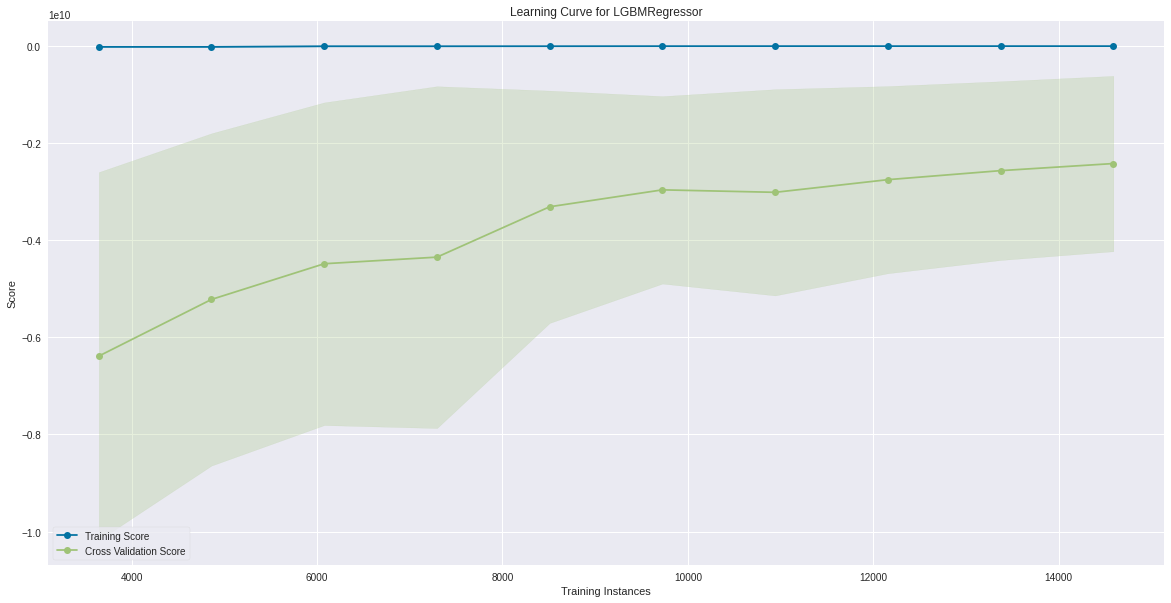

In [80]:
# Instanciando o modelo e visualizando a curva de aprendizado
model = lgbm_opt_final
cv = KFold(n_splits=10, random_state=42)
sizes = np.linspace(0.25, 1, 10)

visualizer = LearningCurve(model,cv=cv, train_sizes=sizes, scoring='neg_mean_squared_error')

visualizer.fit(X_train2, y_train)        
visualizer.show()

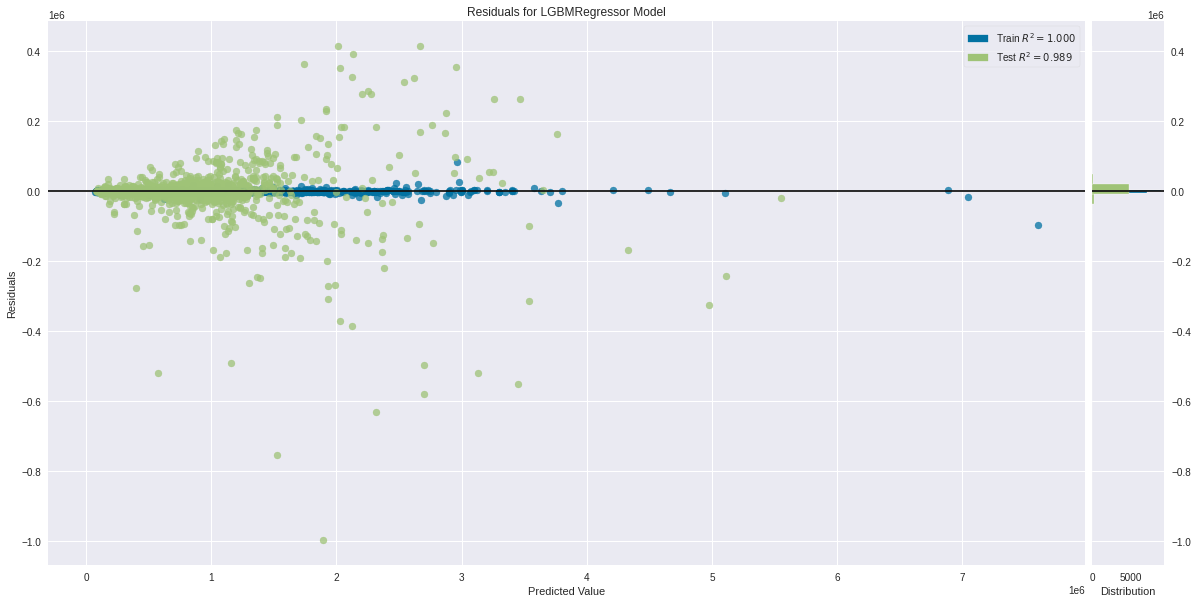

In [81]:
# Instanciando o modelo e visualizando o resíduos
model = lgbm_opt_final
visualizer = ResidualsPlot(model)

visualizer.fit(X_train2, y_train)  
visualizer.score(X_test2, y_test)  
visualizer.show()

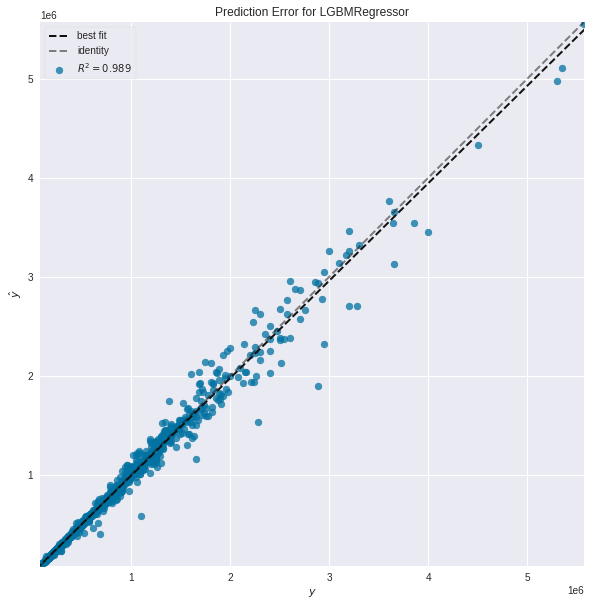

In [82]:
# Instanciando o modelo e visualizando os erros das previsões
model = lgbm_opt_final
visualizer = PredictionError(model)

visualizer.fit(X_train2, y_train)  
visualizer.score(X_test2, y_test)
visualizer.show()     

Embora tenhamos preparado a nossa variável target aplicando transformação de boxcox, optamos por utilizar ela sem aplicar transformação, pois o ganho em performance no modelo em questão de redução dos erros foi considerável.
O modelo final já otimizado e com as melhores features selecionadas apresentou um **MSE=1672439030**, **RMSE= 40895**, **MAE= 9461** e **R²=0,989**. Esses resultados foram bastante satisfatórios em relação aos demais modelos criados nesse projeto.

O próximo passo desse projeto trata-se da realização do deploy do modelo atual para realizar previsões refernte a novos imóveis da cidade de Seattle. 
